#### Importo librerias y funciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sys
import seaborn as sns
import os
import glob

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Activation, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint, LambdaCallback

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

#from tensorflow.keras.datasets import fashion_mnist
#from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# EDA

In [23]:
clases = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
K.clear_session()
train_imgs = np.load('kaggle/train_images.npy')
train_labels = pd.read_csv('kaggle/train_labels.csv')
x_train, x_val, y_train, y_val = train_test_split(train_imgs, train_labels, test_size=0.15, random_state=28)

x_train = x_train / 255.0
x_val = x_val / 255.0

### Visualizo Datos

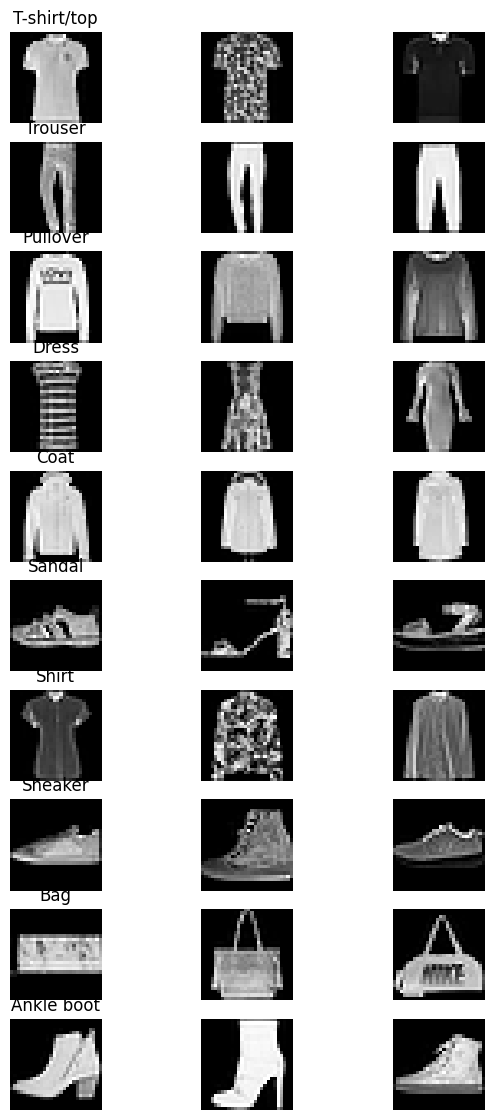

In [24]:
fig1, axs = plt.subplots(10, 3, figsize=(7, 14))
for i in range(10):
    indice = np.where(y_train == i)[0] #encuentra donde coincide el label
    np.random.shuffle(indice) #selecciona random de ese subset de data que encontro
    for j in range(3):
        axs[i,j].imshow(x_train[indice[j]], cmap='gray')
        axs[i,j].axis('off') #me saca las escalas
        if j == 0:
            axs[i,j].set_title(clases[i])
plt.show()

### Histograma de intensidad

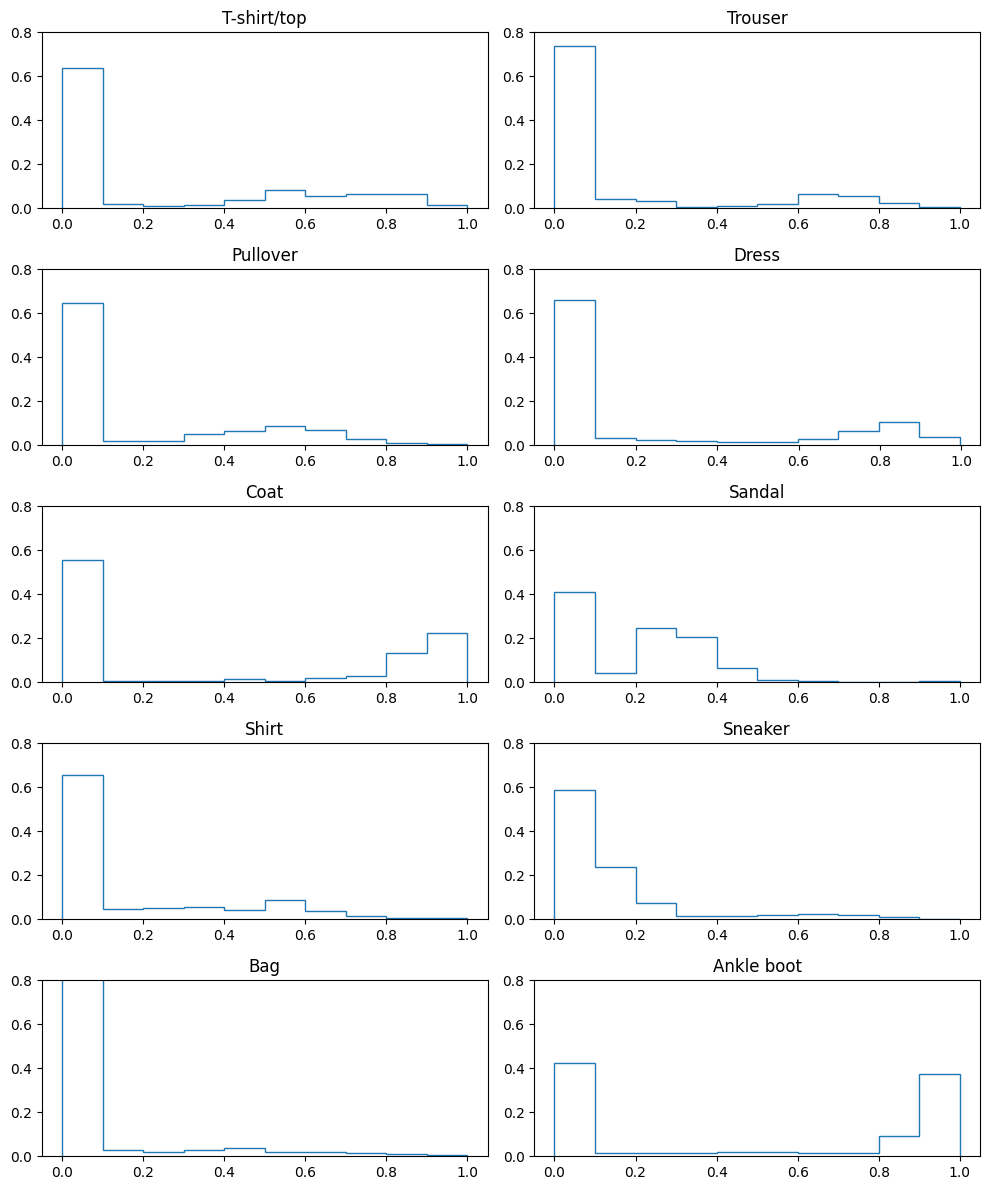

In [30]:
fig, axs = plt.subplots(5, 2, figsize=(10, 12))
for indice, ax in enumerate(axs.flatten()):
    counts, bins = np.histogram(x_train[indice].flatten())
    ax.stairs(counts/x_train[indice].flatten().size, bins)
    ax.set_ylim([0,.8])
    ax.set_title(str(clases[indice]))

plt.tight_layout()
plt.show()

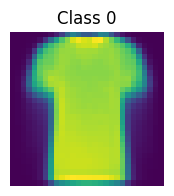

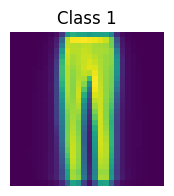

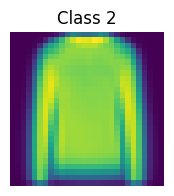

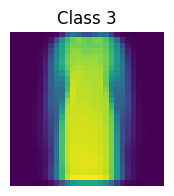

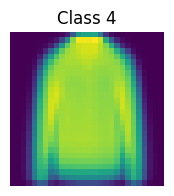

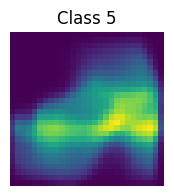

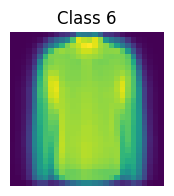

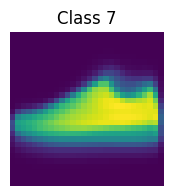

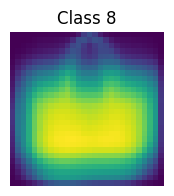

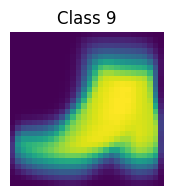

In [32]:
class_proms = []
for i in range(10):
    indice = np.where(y_train==i)[0]
    class_images = x_train[indice]
    class_pr = np.mean(class_images, axis=0)
    class_proms.append(class_pr)

for i, class_average in enumerate(class_proms):
    plt.figure(figsize=(2, 2))
    plt.imshow(class_average.reshape(28, 28))#, cmap='gray')
    plt.title(f'Class {i}')
    plt.axis('off')
    plt.show()


# Modelo de Regresion Softmax

In [ ]:
K.clear_session()
train_imgs = np.load('/kaggle/train_images.npy')
train_labels = pd.read_csv('/kaggle/train_labels.csv')
x_train, x_val, y_train, y_val = train_test_split(train_imgs, train_labels, test_size=0.15, random_state=28)

x_train = x_train / 255.0
x_val = x_val / 255.0
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

Creo un modelo cuya única capa sea la softmax (se ignora la presencia del Flatten ya que es análogo a un reshape)

In [ ]:
K.clear_session()

# Definir el modelo de clasificación
model = tf.keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation="softmax"),
])

In [ ]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:

# Entrenar el modelo
model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))


In [ ]:

# Evaluar el modelo en el conjunto de prueba
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=2)
print('Exactitud en el conjunto de prueba:', val_acc)

# Modelo MLP

##### HELPER

In [8]:
label_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
label_dict = {label: label_names[label] for label in range(10)}

def plot_mapping_boundaries(des_layer_out, des_layer_in):
    desired_layer = model.layers[des_layer_out]
    auxModel = keras.models.Model(inputs=model.input, outputs=desired_layer.output)
    layer_outputs = auxModel.predict(x_val)
    auxdf = pd.DataFrame()
    auxdf['zero'] = layer_outputs[:, 0]
    auxdf['one'] = layer_outputs[:, 1]
    results = [label_dict[np.argmax(y)] for y in y_val]
    auxdf['label'] = results
    desired_layer = model.layers[des_layer_in]
    kkk = keras.models.Model(inputs=desired_layer.input, outputs=model.output)

    #grilla
    x_min = -3
    x_max = 4
    y_min = -1
    y_max = 4
    step = 100
    x_values = np.logspace(x_min, x_max, num=step)
    y_values = np.logspace(y_min, y_max, num=step)
    X, Y = np.meshgrid(x_values, y_values)

    #Formateo los datos para que sean aptos como inputs 
    points = np.column_stack((X.flatten(), Y.flatten()))

    # Map the input data to the desired layer
    sdf = kkk.predict(points)

    sdf_sparse = np.zeros(sdf.shape[0]).astype(int)
    for i in range(sdf.shape[0]):
        sdf_sparse[i] = np.argmax(sdf[i]).astype(int)

    sdfdf = pd.DataFrame()
    sdfdf['X'] = points[:,0]
    sdfdf['Y'] = points[:,1]
    resultssdf = []
    for i in range(sdfdf.shape[0]):
        resultssdf.append(label_dict[sdf_sparse[i]])
    sdfdf['label'] = resultssdf

    plt.figure(figsize=(10,10))
    sns.scatterplot( x="X", y="Y",
        hue = 'label',
        hue_order = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
        palette=sns.color_palette("rocket", 10),
        data=sdfdf,
        legend=None,
        alpha=0.4)
    sns.scatterplot( x="zero", y="one",
        hue = 'label',
        hue_order = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
        palette=sns.color_palette("rocket", 10),
        data=auxdf,
        marker="o",    
        legend="full",
        alpha=0.8)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-3,1e4)
    plt.ylim(1e-1,1e4)
    plt.grid(True)

#### DATA

In [4]:
K.clear_session()
train_imgs = np.load('kaggle/train_images.npy')
train_labels = pd.read_csv('kaggle/train_labels.csv')
x_train, x_val, y_train, y_val = train_test_split(train_imgs, train_labels, test_size=0.15, random_state=28)

x_train = x_train / 255.0
x_val = x_val / 255.0


#### Modelo

In [12]:
model = tf.keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(5000, activation='relu', kernel_initializer='glorot_normal'),
    layers.Dropout(.5),
    layers.BatchNormalization(synchronized=True),
    
    layers.Dense(5000, kernel_initializer='glorot_normal',activation='relu'),
    layers.Dropout(.5),
    layers.BatchNormalization(synchronized=True),
    
    layers.Dense(5000, kernel_initializer='glorot_normal',activation='relu'),
    layers.Dropout(.5),
    layers.BatchNormalization(synchronized=True),
    layers.Dense(1000, kernel_initializer='glorot_normal',activation="softmax"),
    #layers.Dense(10)
])
model.summary()
print(len(model.layers))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 5000)              3925000   
                                                                 
 dropout_9 (Dropout)         (None, 5000)              0         
                                                                 
 batch_normalization_9 (Batc  (None, 5000)             20000     
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 5000)              25005000  
                                                                 
 dropout_10 (Dropout)        (None, 5000)              0         
                                                      

##### Especifico el optimizador como el ejemplificado en keras

In [13]:
tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.99,
    beta_2=1,#0.999,
    epsilon=0,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=1,#0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
   name='Adam',
)

##### Compilo

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

##### Adapto los Callbacks a lo que creo necesitar

In [10]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    restore_best_weights=True 
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,  
    patience=5,  
    min_lr=0.0000001  
)

checkpoint = ModelCheckpoint('path_para_guardar_checkpoint.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 * 0.95 ** epoch)

##### Entreno y testeo

In [16]:
history = model.fit(x_train, y_train,batch_size=2048, epochs=100, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint])
model = tf.keras.models.load_model('path_para_guardar_checkpoint.h5')

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(x_val, y_val, verbose=2)
print('Exactitud en el conjunto de prueba:', test_acc)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 1.1092 - accuracy: 0.7411
Epoch 1: val_loss improved from inf to 3.75597, saving model to path_para_guardar_checkpoint.h5
25/25 [==============================] - 242s 10s/step - loss: 1.1092 - accuracy: 0.7411 - val_loss: 3.7560 - val_accuracy: 0.5974 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.7917
Epoch 2: val_loss improved from 3.75597 to 2.80507, saving model to path_para_guardar_checkpoint.h5
25/25 [==============================] - 257s 10s/step - loss: 0.6991 - accuracy: 0.7917 - val_loss: 2.8051 - val_accuracy: 0.6484 - lr: 9.5000e-05
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.8131
Epoch 3: val_loss improved from 2.80507 to 2.06457, saving model to path_para_guardar_checkpoint.h5
25/25 [==============================] - 267s 11s/step - loss: 0.5929 - accuracy: 0.8131 - val_loss: 2.0646 - val_accuracy:

KeyboardInterrupt: 

In [17]:
model = tf.keras.models.load_model('path_para_guardar_checkpoint.h5')

## 1.3
Se emplea un modelo de prueba donde se agrega una capa de tamaño 2, con el fin de mapear los datos de la entrada a la salida de la capa y superponerlos con los umbrales de decision.

Este modelo no es necesariamente el mejor, se emplea una prueba para mostrar lo pedido únicamente.

##### Helper

In [2]:
def get_model(activations=['relu', 'relu']):
    output_size = 10
    model_plane = Sequential()
    model_plane.add(Flatten(input_shape=x_train.shape[1:]))
    model_plane.add(Dense(3000, activation=activations[0],  name='middle1', kernel_initializer='glorot_normal'))
    model_plane.add(Dense(3000, activation=activations[0],  name='middle2', kernel_initializer='glorot_normal'))
    model_plane.add(Dense(3000, activation=activations[0],  name='middle3', kernel_initializer='glorot_normal'))
    # model_plane.add(LeakyReLU())
    model_plane.add(Dense(2))#, activation=activations[1], name='middle2', kernel_initializer='glorot_normal'))
    # model_plane.add(LeakyReLU())
    model_plane.add(Dense(output_size, activation='softmax',  kernel_initializer='glorot_normal', name='salida'))
    return model_plane

##### MODEL

In [3]:
K.clear_session()
# Load the data
train_imgs = np.load('kaggle/train_images.npy')
train_labels = pd.read_csv('kaggle/train_labels.csv')
x_train, x_val, y_train, y_val = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=28)

# Normalize the images
x_train = x_train / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_val.reshape(-1, 28, 28, 1)
x_train = x_train.reshape(-1, 28,28)
#x_val = x_val.reshape(-1, 28, 28)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

In [4]:
batch_size=2048
K.clear_session()
model = get_model(activations=['relu', 'relu'])

In [5]:
checkpointer = ModelCheckpoint(filepath='three-layer-2d_2.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_accuracy')
# clr = CyclicLR(1e-6, 1e-4, 8*int(len(x_train)/batch_size))
optim = Adam(lr=1e-4) # 1e-06
model.compile(loss = 'categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

c:\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [6]:
model.fit(x_train, 
          y_train,
          epochs=20, batch_size=batch_size, 
          #verbose=1, 
          validation_data=(x_val, y_val), 
          callbacks=[checkpointer],
         )

Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 1.7977 - accuracy: 0.3299
Epoch 1: val_accuracy improved from -inf to 0.40117, saving model to three-layer-2d_2.mnist.hdf5
24/24 [==============================] - 66s 3s/step - loss: 1.7977 - accuracy: 0.3299 - val_loss: 1.5458 - val_accuracy: 0.4012
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 1.4688 - accuracy: 0.4340
Epoch 2: val_accuracy improved from 0.40117 to 0.44667, saving model to three-layer-2d_2.mnist.hdf5
24/24 [==============================] - 64s 3s/step - loss: 1.4688 - accuracy: 0.4340 - val_loss: 1.4213 - val_accuracy: 0.4467
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 1.3649 - accuracy: 0.4700
Epoch 3: val_accuracy improved from 0.44667 to 0.47650, saving model to three-layer-2d_2.mnist.hdf5
24/24 [==============================] - 65s 3s/step - loss: 1.3649 - accuracy: 0.4700 - val_loss: 1.3424 - val_accuracy: 0.4765
Epoch 4/20
24/24 [================

In [9]:
model = tf.keras.models.load_model('three-layer-2d_2.mnist.hdf5')

In [10]:
model.summary()
print(len(model.layers))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 middle1 (Dense)             (None, 3000)              2355000   
                                                                 
 middle2 (Dense)             (None, 3000)              9003000   
                                                                 
 middle3 (Dense)             (None, 3000)              9003000   
                                                                 
 dense (Dense)               (None, 2)                 6002      
                                                                 
 salida (Dense)              (None, 10)                30        
                                                                 
Total params: 20,367,032
Trainable params: 20,367,032
No

In [11]:
print(len(model.layers)-2)

4


##### GRAPH

313/313 [==============================] - 0s 1ms/step


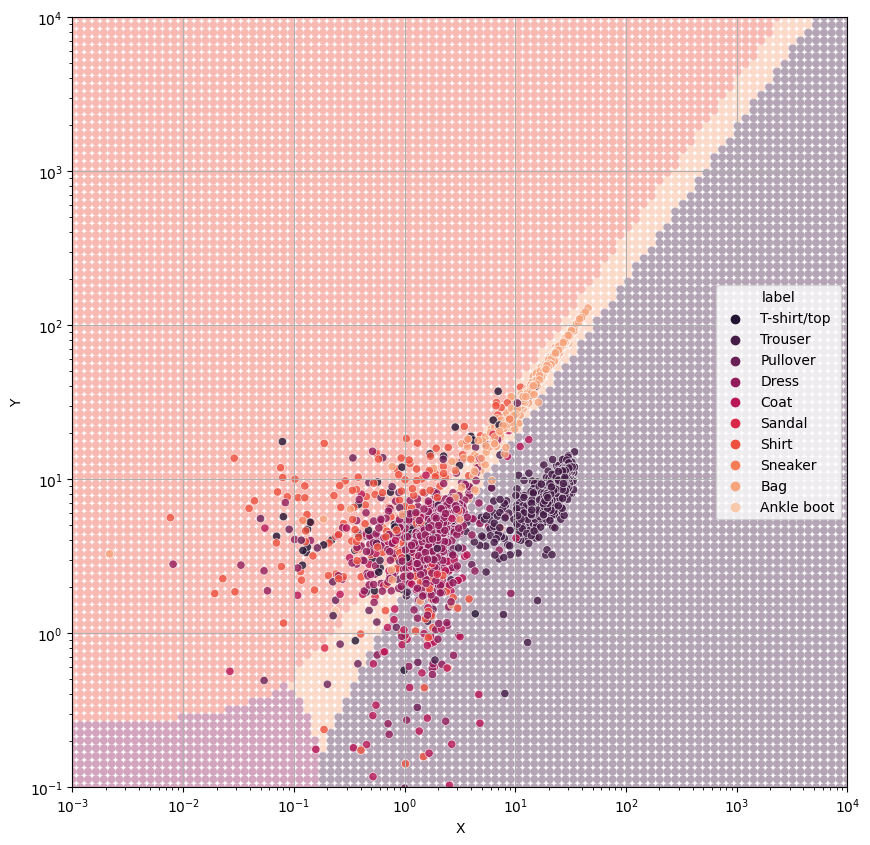

In [12]:
plot_mapping_boundaries(len(model.layers)-2, len(model.layers)-1)

##### Repo de la catedra method

In [20]:
model = tf.keras.models.load_model('three-layer-2d_2.mnist.hdf5')
model_trunc = Model(model.input, model.layers[-2].output)
model_trunc.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_input (InputLayer)  [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 middle1 (Dense)             (None, 3000)              2355000   
                                                                 
 middle2 (Dense)             (None, 3000)              9003000   
                                                                 
 middle3 (Dense)             (None, 3000)              9003000   
                                                                 
 dense (Dense)               (None, 2)                 6002      
                                                                 
Total params: 20,367,002
Trainable params: 20,367,002
Non-t

In [21]:
predictions = model_trunc.predict(np.vstack([x_train, x_val]), verbose=1)
maxs = np.max(predictions, axis=0)
mins = np.min(predictions, axis=0)
print(maxs, mins)

1875/1875 [==============================] - 52s 28ms/step
[ 49.41792 140.53745] [-100.21487  -95.13334]


In [22]:
predictions_train = model_trunc.predict(x_train, verbose=1)

1500/1500 [==============================] - 47s 31ms/step


In [23]:
N = 500
x1, x2 = np.meshgrid(np.linspace(mins[0], maxs[0], N), np.linspace(mins[1], maxs[1], N))
x_mesh = np.c_[x1.ravel(), x2.ravel()]
model_last_trunc = Sequential()
model_last_trunc.add(Dense(10, input_shape=(2,)))
model_last_trunc.set_weights(model.get_layer('salida').get_weights())
pred_mesh = model_last_trunc.predict(x_mesh, verbose=1)
Z = np.argmax(pred_mesh, axis=1).reshape(x1.shape)/10

7813/7813 [==============================] - 14s 2ms/step


In [24]:
predictions_val = model_trunc.predict(x_val, verbose=1)


375/375 [==============================] - 17s 45ms/step


C:\Users\sebas\AppData\Local\Temp\ipykernel_9620\929676580.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(class_predictions[:, 0], class_predictions[:, 1], c=colors[i], s=5, alpha=1, label=str(i))


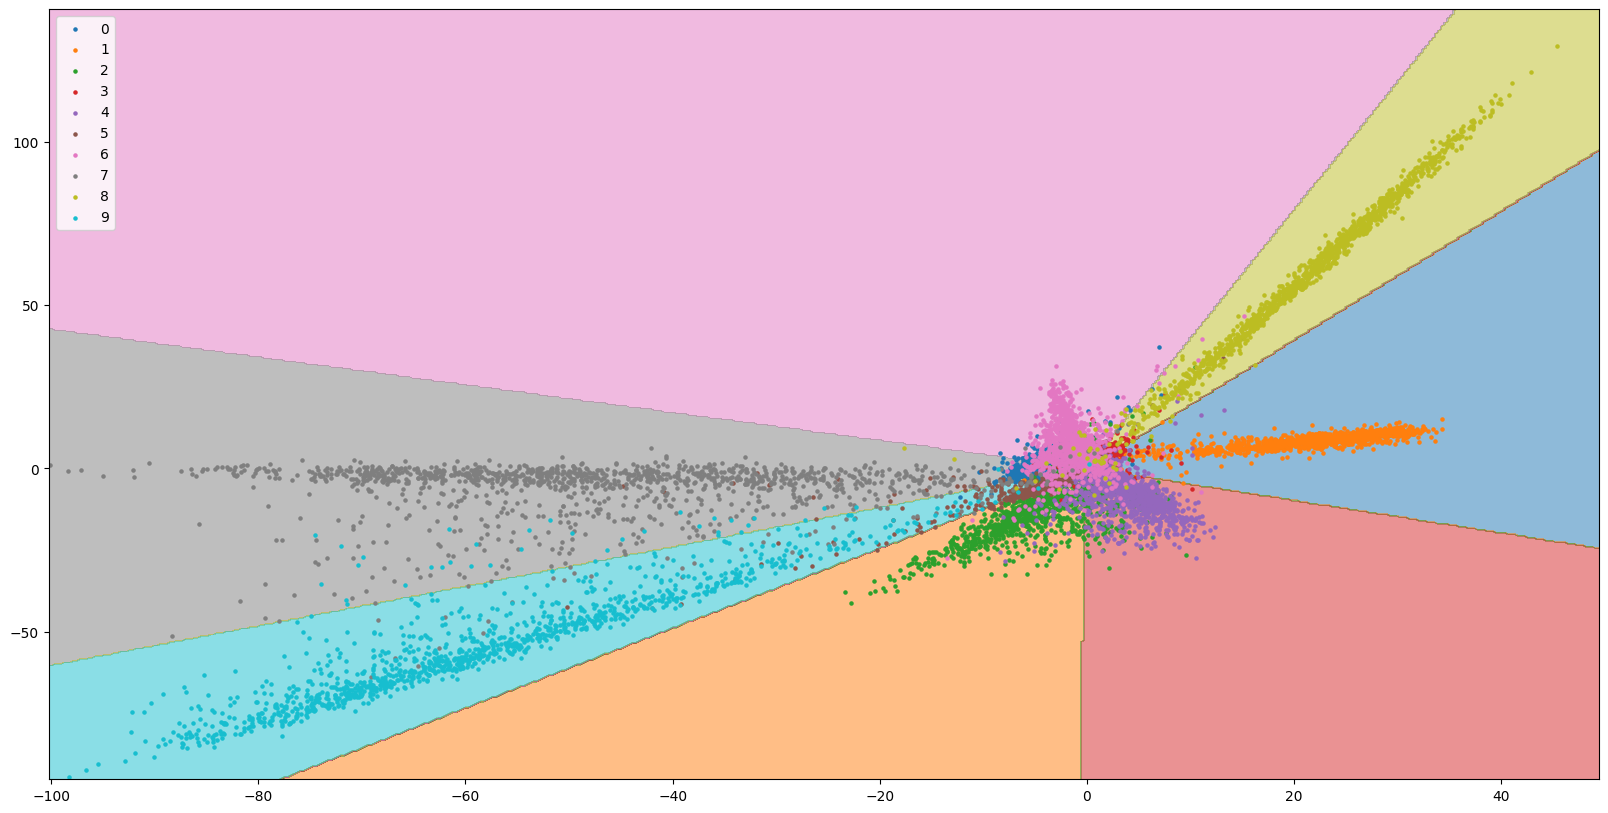

In [25]:
plt.figure(figsize=(20, 10))

# Adjust the number of contour levels
plt.contourf(x1, x2, Z, 10, cmap=plt.cm.tab10, alpha=0.5)

colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    class_indices = np.argmax(y_val, axis=1) == i
    class_predictions = predictions_val[class_indices]
    if len(class_predictions) > 0:
        plt.scatter(class_predictions[:, 0], class_predictions[:, 1], c=colors[i], s=5, alpha=1, label=str(i))

plt.legend()
plt.show()

##### Another version of the plot
Es solo para jugar con las diferentes paletas, alphas y tamaños

C:\Users\sebas\AppData\Local\Temp\ipykernel_9620\1464661260.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(class_predictions[:, 0], class_predictions[:, 1], c=colors[i], s=5, label=str(i))


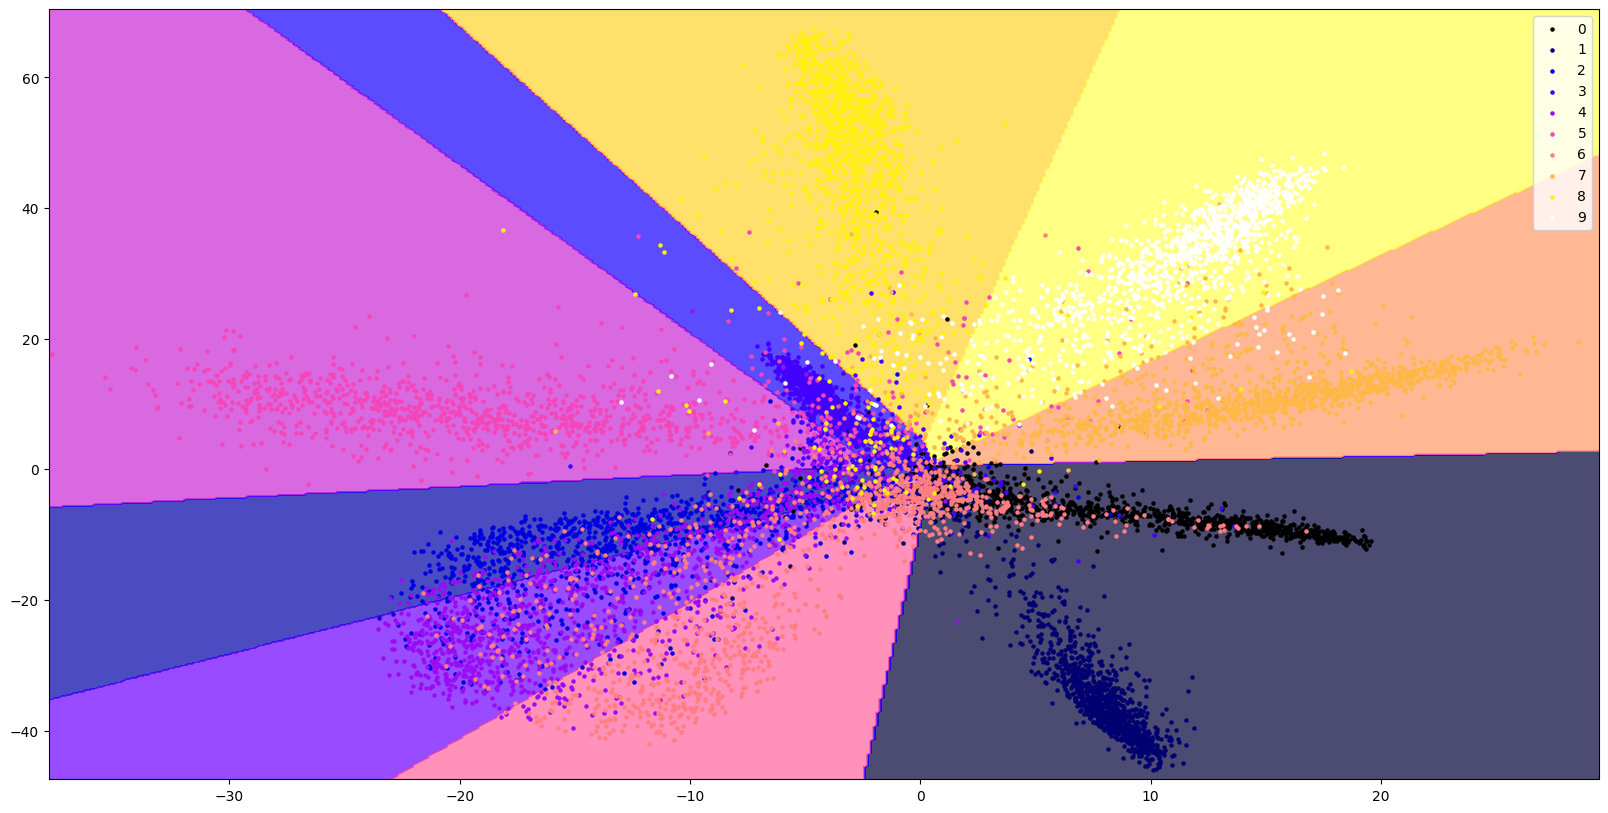

In [19]:
plt.figure(figsize=(20, 10))
plt.contourf(x1, x2, Z, 10, cmap=plt.cm.gnuplot2, alpha=0.7)
colors = plt.cm.gnuplot2(np.linspace(0, 1, 10))

for i in range(10):
    class_indices = np.argmax(y_val, axis=1) == i
    class_predictions = predictions_val[class_indices]
    if len(class_predictions) > 0:
        plt.scatter(class_predictions[:, 0], class_predictions[:, 1], c=colors[i], s=5, label=str(i))

plt.legend()
plt.show()

# Ejemplo para guardar datos de la red y después hacer gráficos comparativos

Además del checkpoint para recuperar el mejor modelo, podemos tomar las métricas de los mismos para luego ser analizadas

##### Guardo el history del modelo

In [ ]:
history_df = pd.DataFrame(history.history)
# Save the DataFrame to a CSV file
history_df.to_csv('path_para_guardar_history.csv', index=False)
test_loss, accuracy, precision, recall, auc = model.evaluate(x_val, y_val, verbose=0)
y_pred = np.argmax(model.predict(x_val), axis=1)
y_val = np.argmax(y_val, axis=1)
f1_macro = f1_score(y_val, y_pred, average='macro')
f1_micro = f1_score(y_val, y_pred, average='micro')

##### Guardo un txt para futuros usos

In [ ]:
sys.stdout = open('path_para_guardar_metrics.txt', 'w')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)
print("F1-ScoreMacro:", f1_macro)
print("F1-ScoreMicro:", f1_micro)

sys.stdout.close()
sys.stdout = sys.__stdout__

##### Ploteo la evolucion de los accuracy y val_Accuracy

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##### Curva ROC

In [ ]:

fpr, tpr, thresholds = roc_curve(y_val, y_pred[:, 1])

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Graficos Comparativos de los diferentes modelos

#### FUNCT HELPS

In [26]:
def extract_columns(csv_file):
    df = pd.read_csv(csv_file)
    accuracy = df['accuracy']
    val_accuracy = df['val_accuracy']
    return accuracy, val_accuracy

def plot_accuracy_vs_val_accuracy(csv_file):
    df = pd.read_csv(csv_file)
    accuracy = df['accuracy']
    val_accuracy = df['val_accuracy']
    
    plt.figure(figsize=(10, 6))
    plt.plot(accuracy, label='accuracy')
    plt.plot(val_accuracy, label='val_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Validation Accuracy ({os.path.basename(csv_file)})')  # Extract only the file name
    plt.legend()
    plt.show()

def plot_epochs_per_file(csv_files):
    num_epochs = []
    file_names = []

    for file in csv_files:
        df = pd.read_csv(file)
        num_epochs.append(len(df))
        file_names.append(os.path.basename(file))

    plt.figure(figsize=(10, 6))
    plt.bar(file_names, num_epochs)
    plt.xlabel('CSV File')
    plt.ylabel('Number of Epochs')
    plt.title('Number of Epochs per File')

    # Add text labels to each bar
    for i, v in enumerate(num_epochs):
        plt.text(i, v, str(v), ha='center', va='bottom')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def create_table_from_text(file):
    with open(file, 'r') as f:
        data = f.read().splitlines()

    labels = []
    numeric_data = []

    for line in data:
        parts = line.split(':')
        labels.append(parts[0].strip())
        numeric_data.append(float(parts[1].strip()))

    table_data = {'Label': labels, 'Numeric Data': numeric_data}
    df = pd.DataFrame(table_data)

    return df

def plot_table_from_text_files(text_files):
    for file in text_files:
        table_title = os.path.basename(file)

        df = create_table_from_text(file)

        plt.figure(figsize=(8, 6))
        plt.axis('off')
        plt.title(table_title)
        plt.table(cellText=df.values, colLabels=df.columns, loc='center')

        plt.show()



#### VS Activaciones

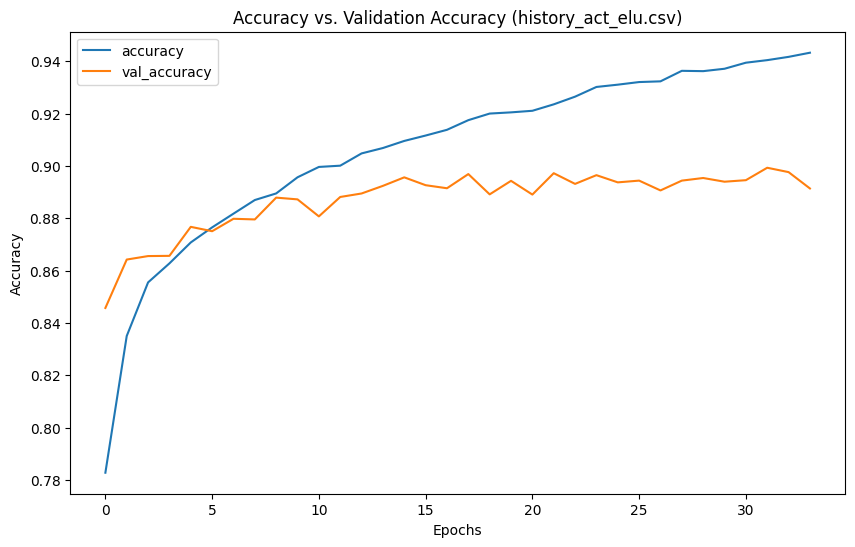

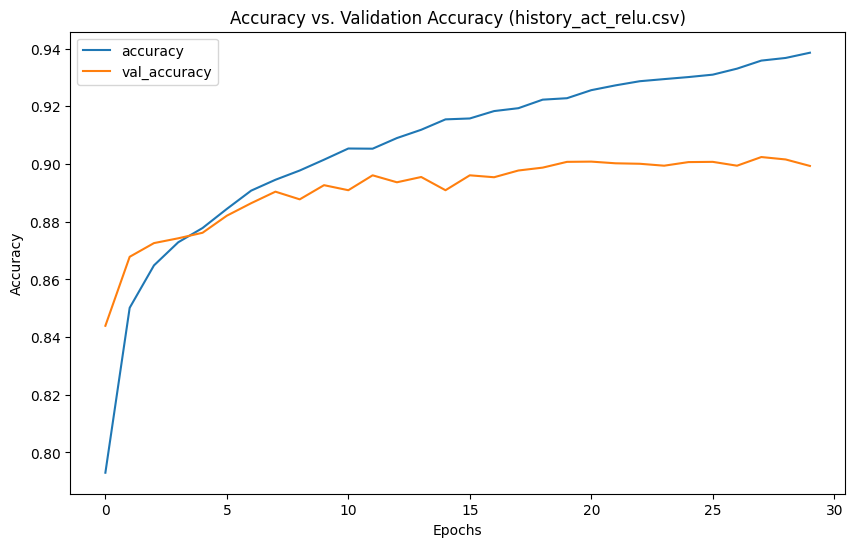

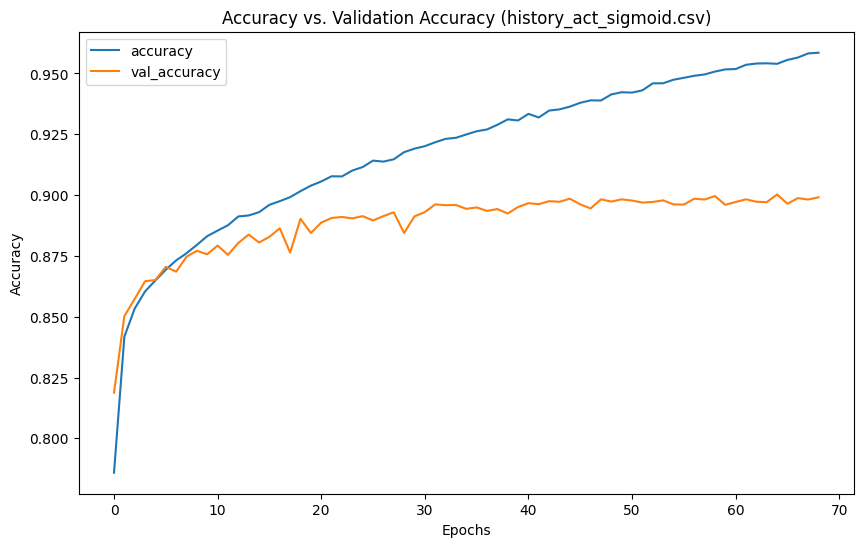

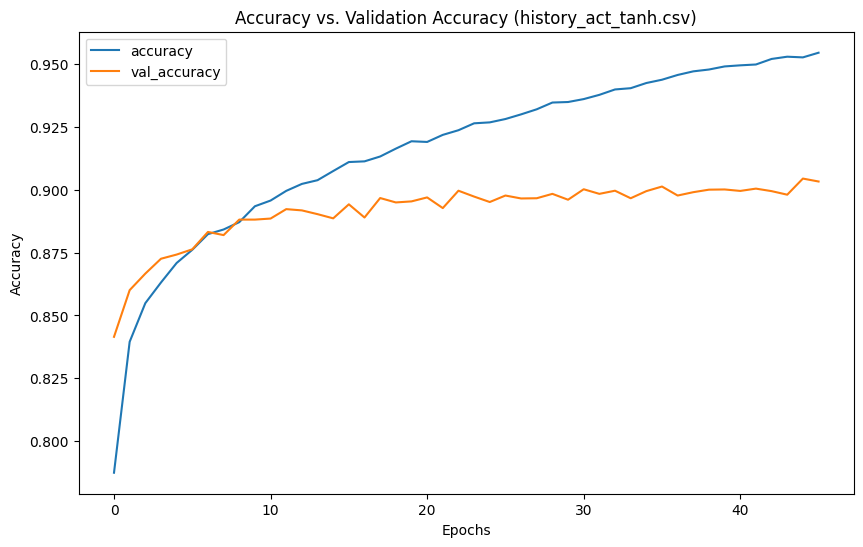

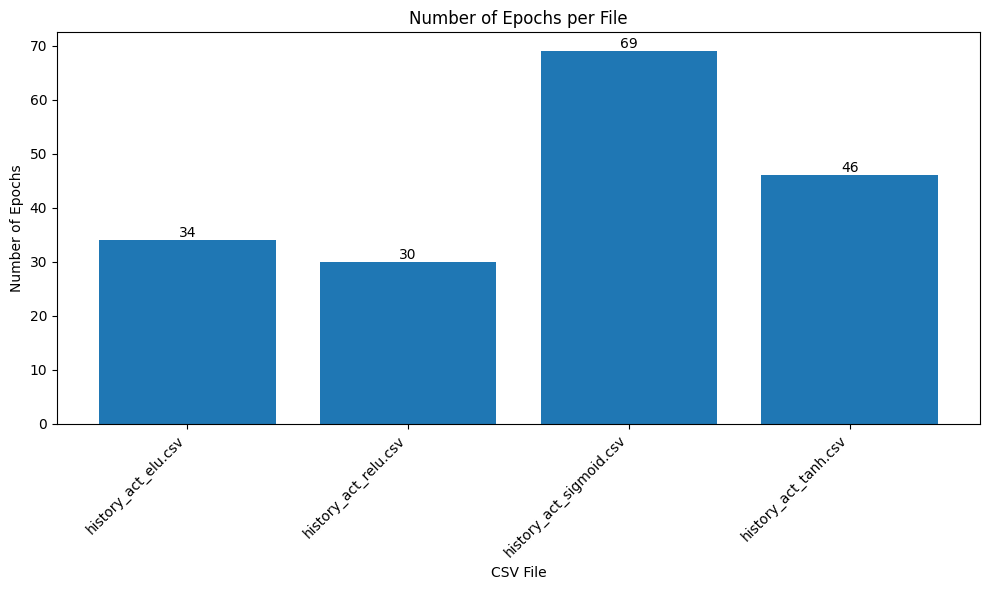

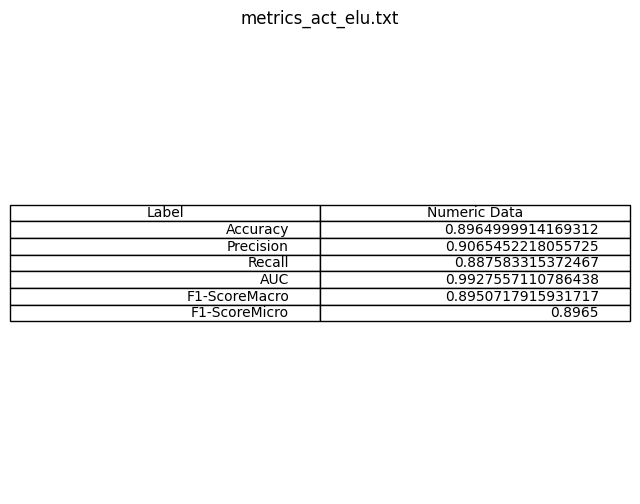

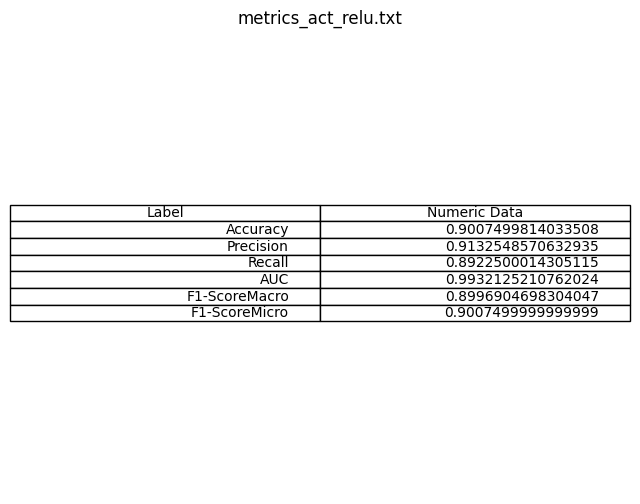

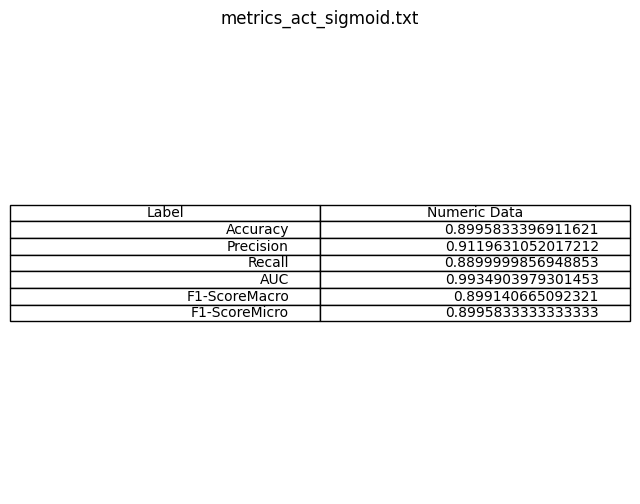

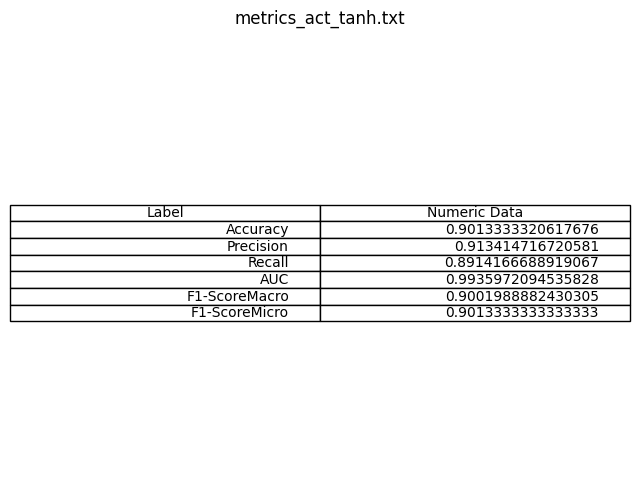

In [27]:
accuracies = []
val_accuracies = []
csv_names = []
csv_files = glob.glob('kaggle/MODELOS/history_act'+'*.csv')  

for file in csv_files:
    accuracy, val_accuracy = extract_columns(file)
    accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)
    csv_names.append(os.path.basename(file))#')file)
for file in csv_files:
    plot_accuracy_vs_val_accuracy(file)

plot_epochs_per_file(csv_files)

text_files = glob.glob('kaggle/MODELOS/metrics_act'+'*.txt') 
plot_table_from_text_files(text_files)

#### VS init

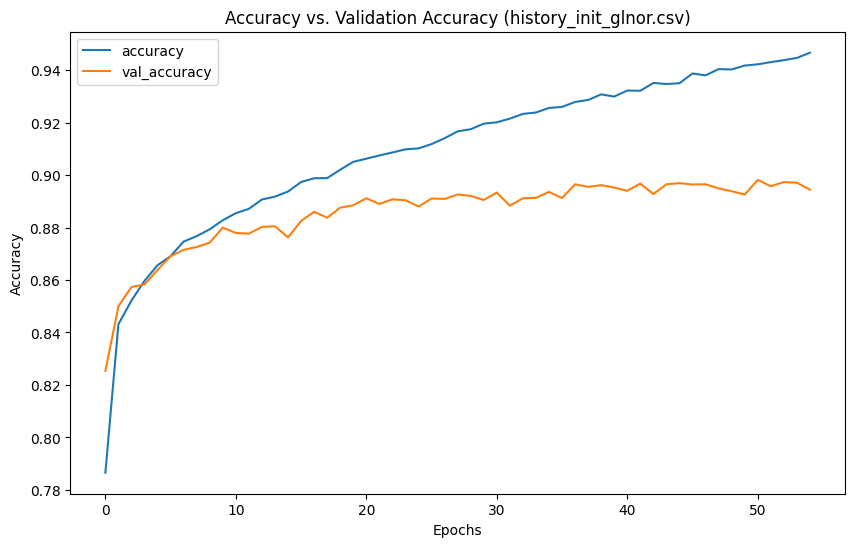

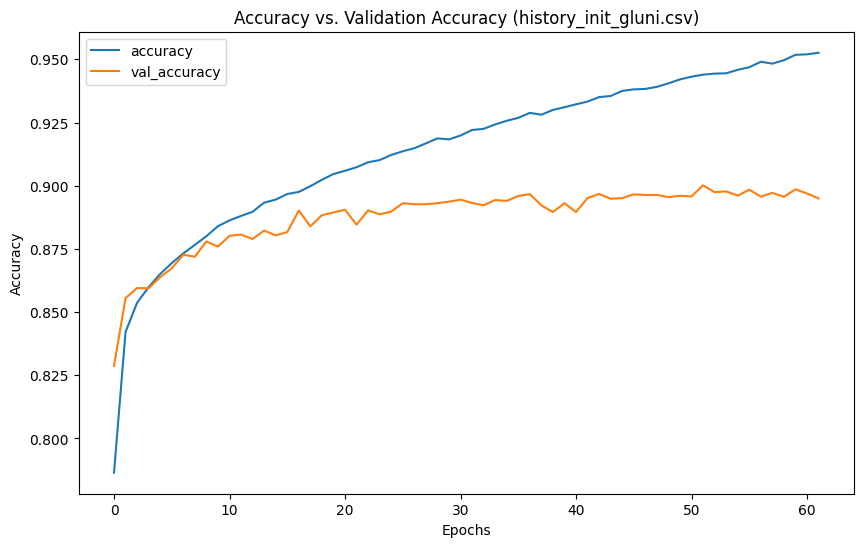

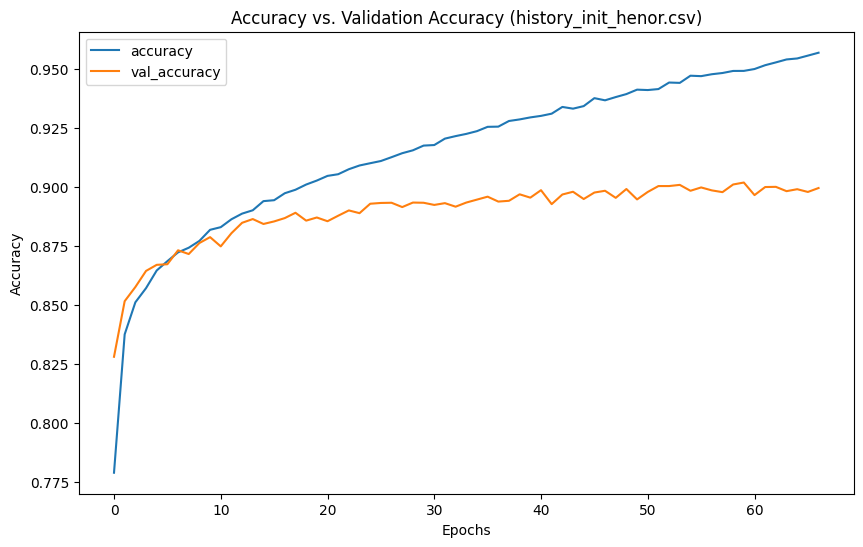

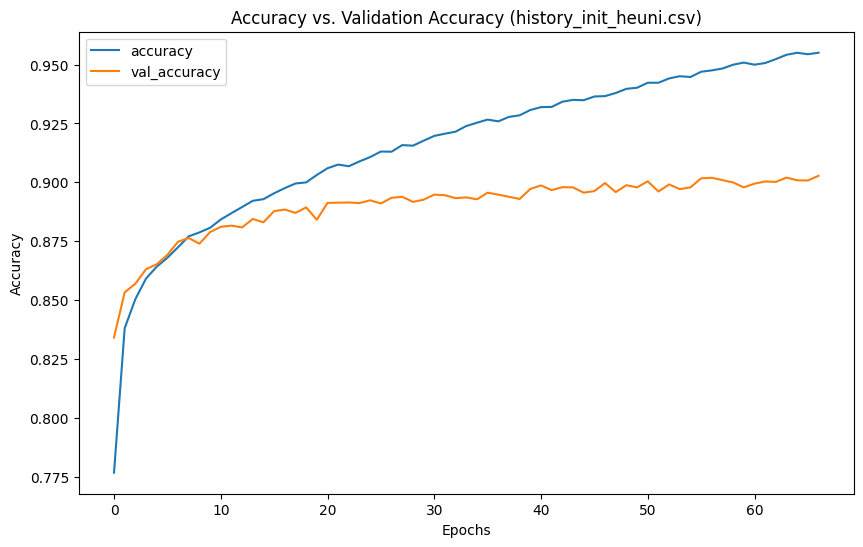

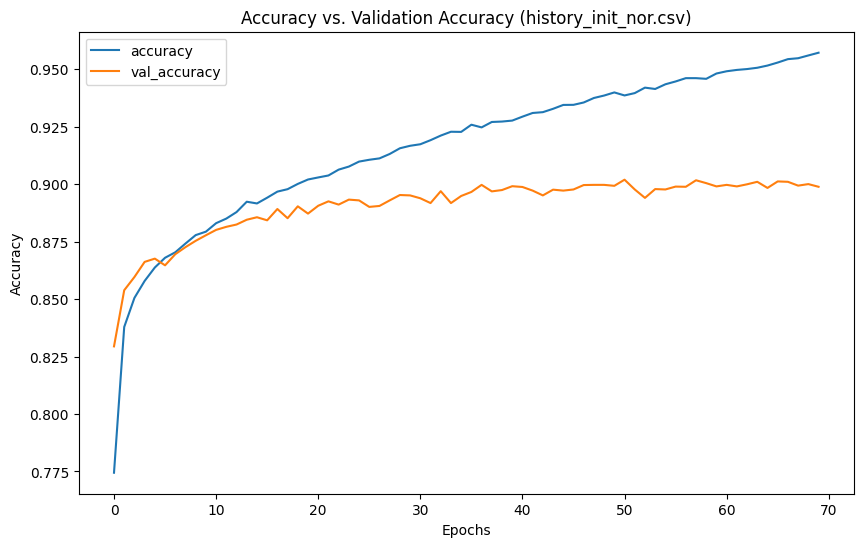

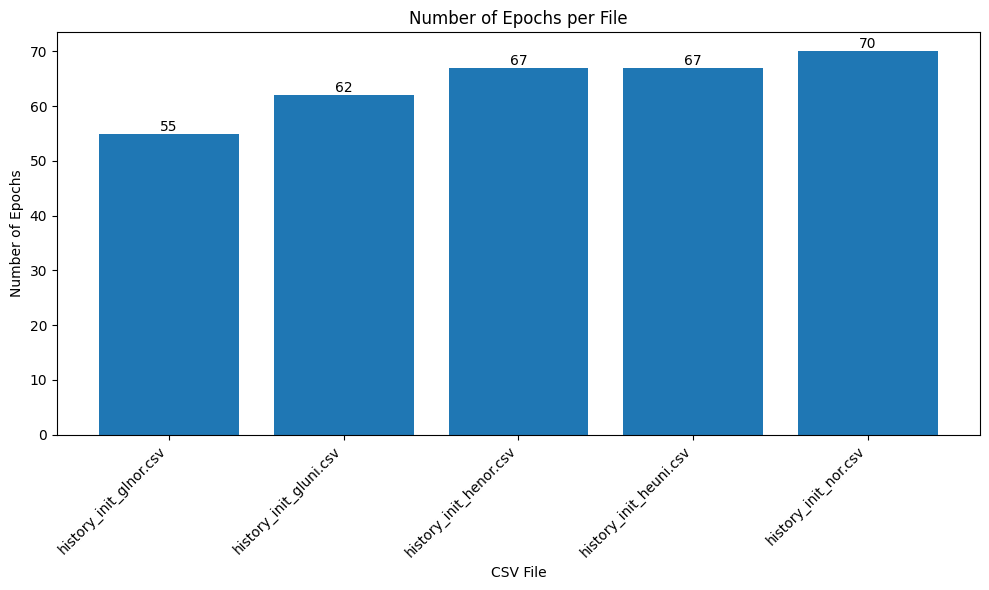

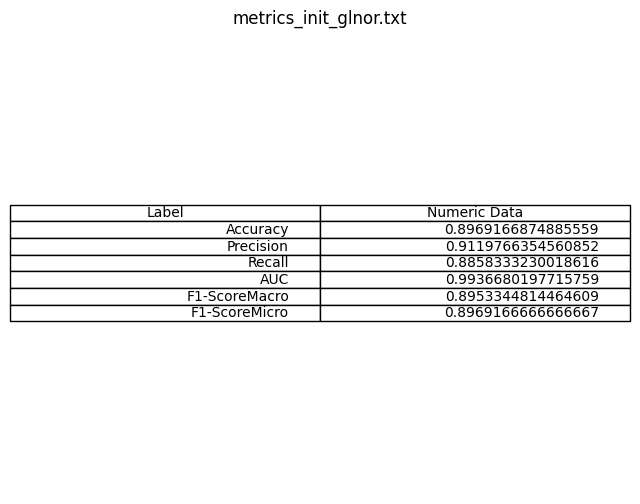

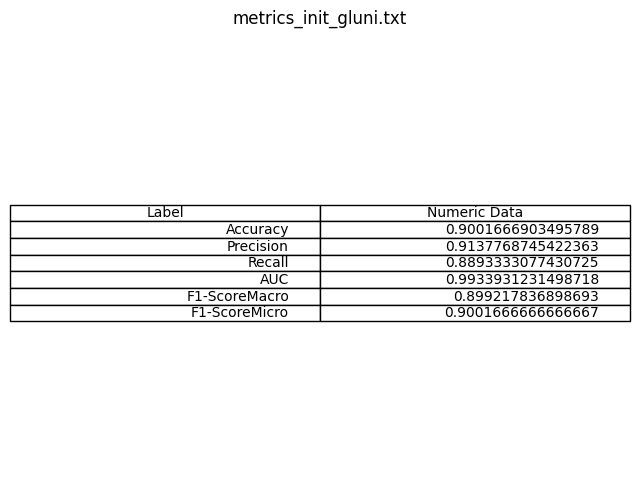

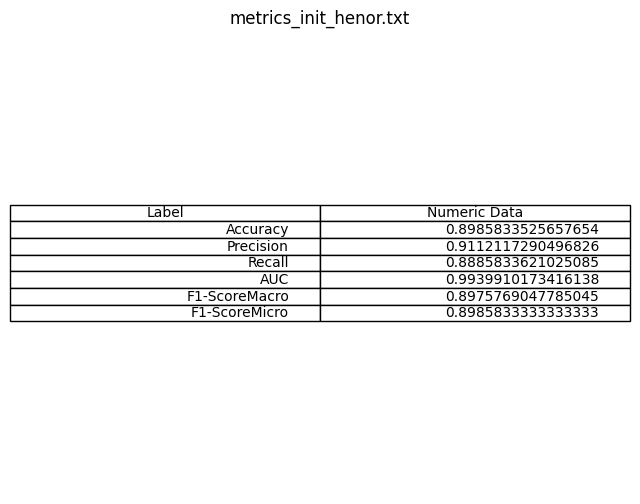

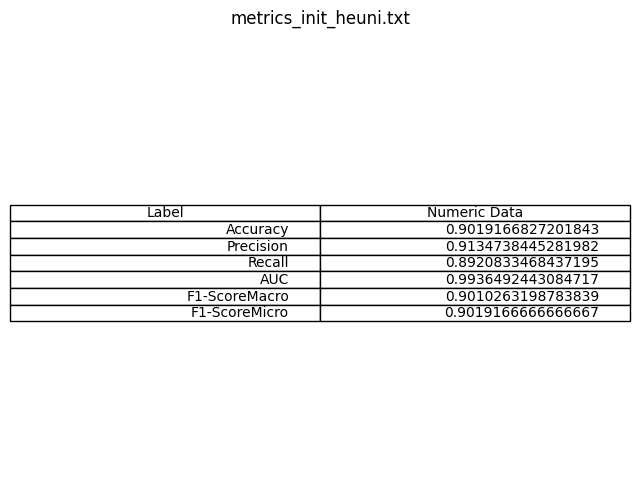

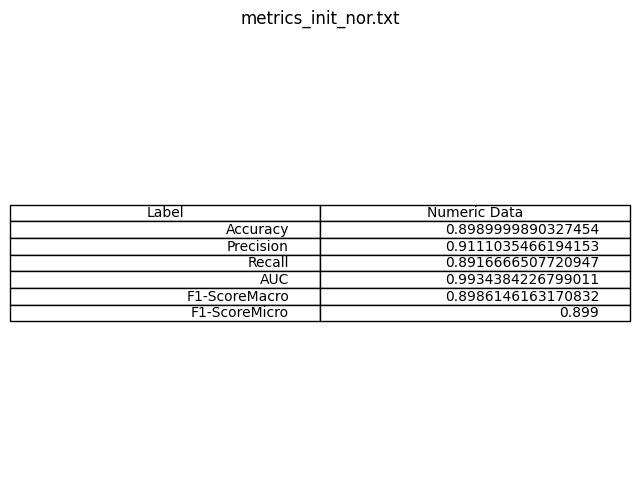

In [28]:
accuracies = []
val_accuracies = []
csv_names = []
csv_files = glob.glob('kaggle/MODELOS/history_init'+'*.csv')  

for file in csv_files:
    accuracy, val_accuracy = extract_columns(file)
    accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)
    csv_names.append(os.path.basename(file))#')file)
for file in csv_files:
    plot_accuracy_vs_val_accuracy(file)

plot_epochs_per_file(csv_files)

text_files = glob.glob('kaggle/MODELOS/metrics_init'+'*.txt') 
plot_table_from_text_files(text_files)

#### VS learningsRate

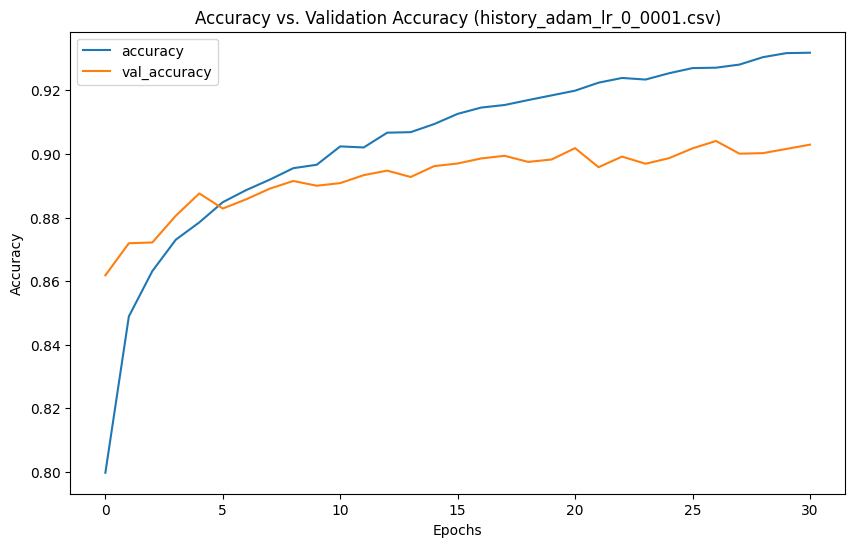

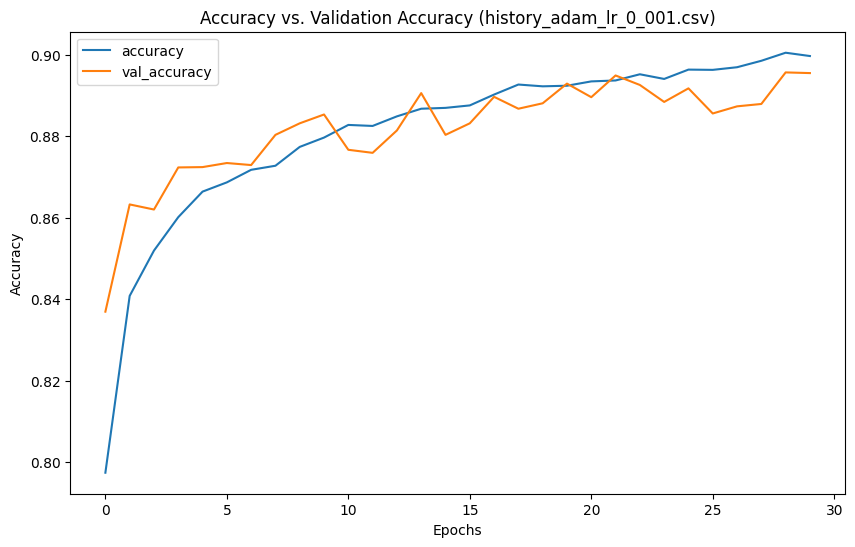

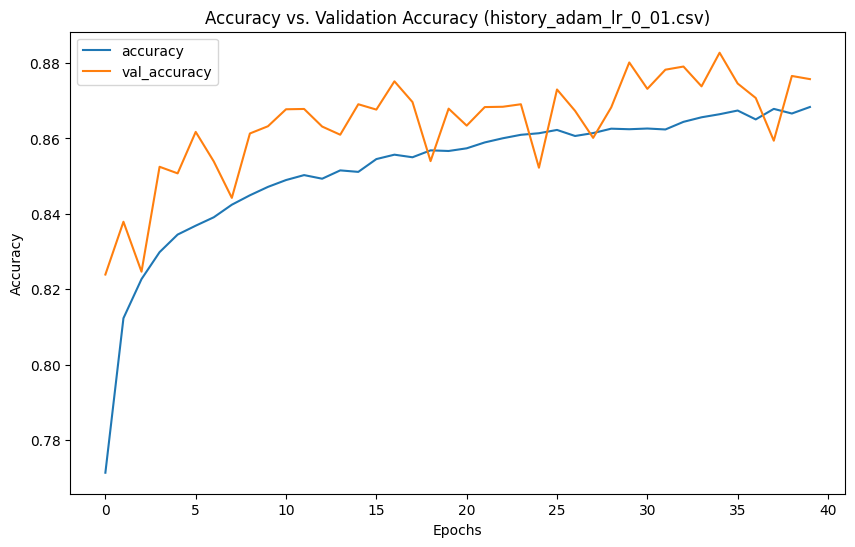

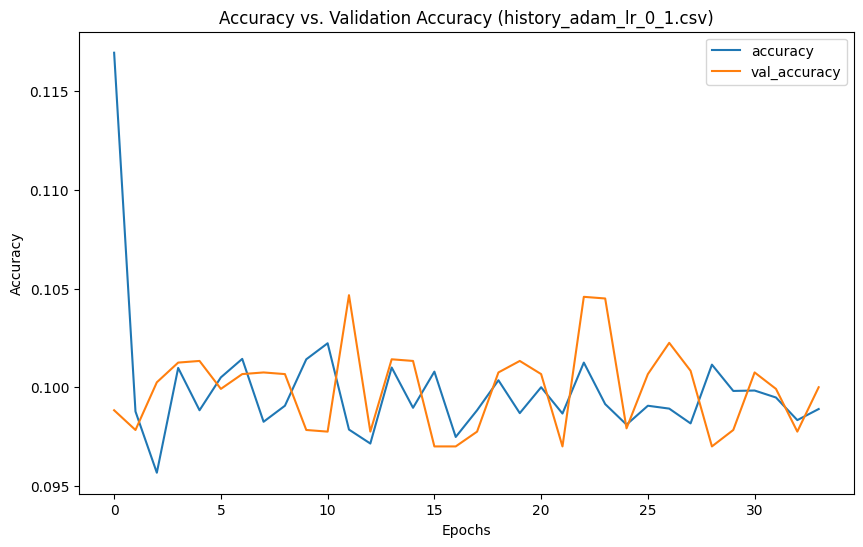

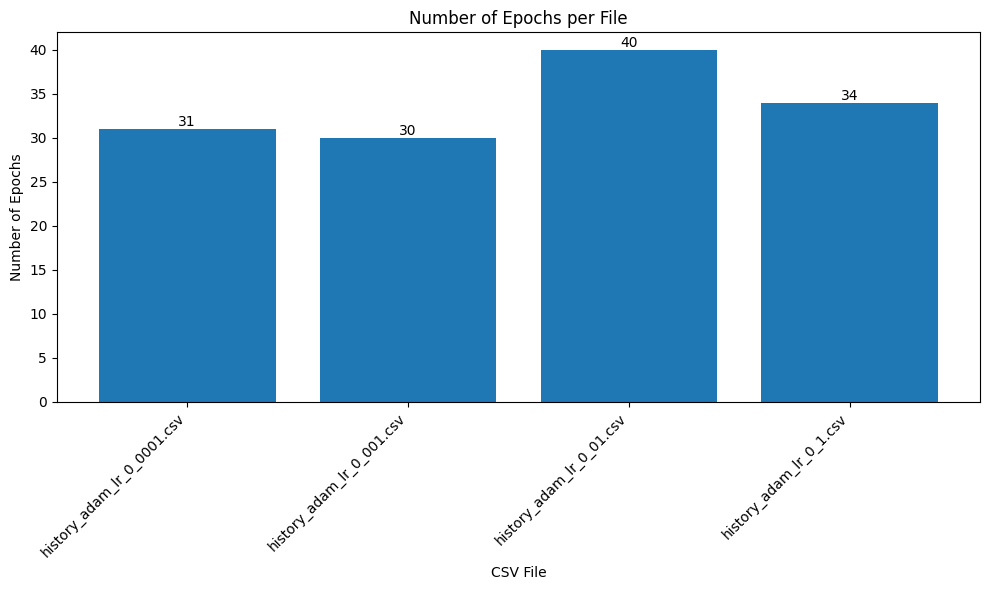

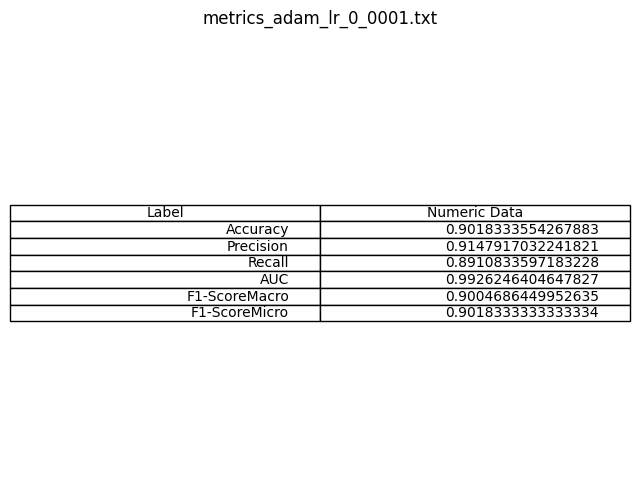

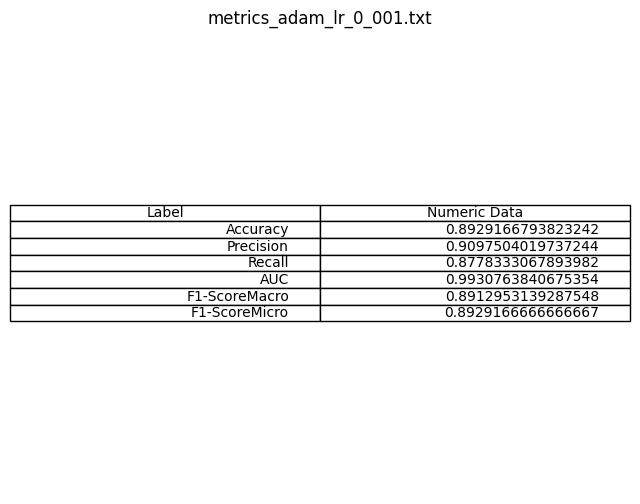

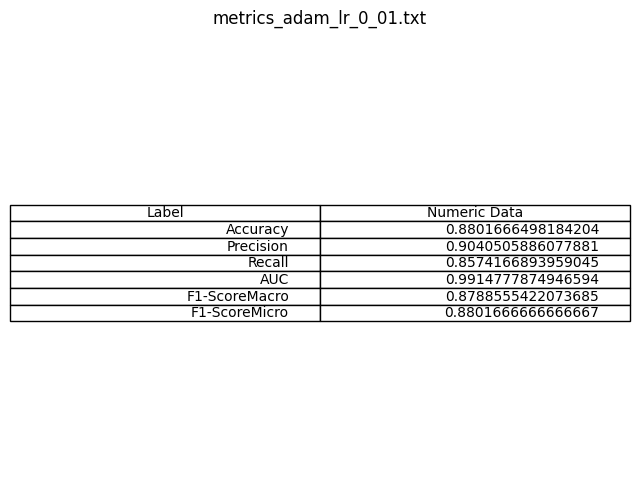

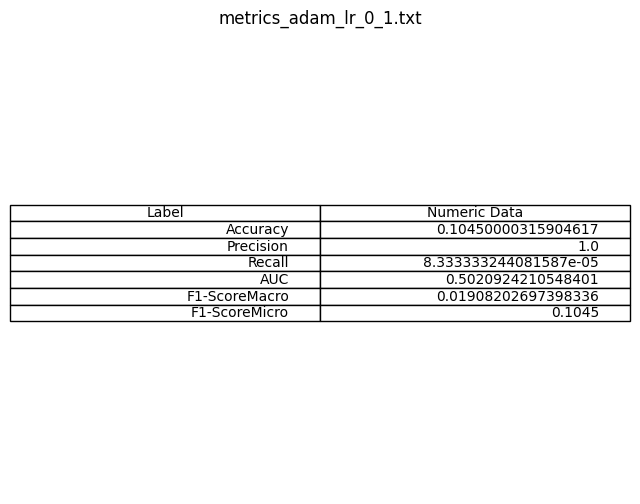

In [29]:
accuracies = []
val_accuracies = []
csv_names = []
csv_files = glob.glob('kaggle/MODELOS/history_adam'+'*.csv')  

for file in csv_files:
    accuracy, val_accuracy = extract_columns(file)
    accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)
    csv_names.append(os.path.basename(file))#')file)
for file in csv_files:
    plot_accuracy_vs_val_accuracy(file)

plot_epochs_per_file(csv_files)

text_files = glob.glob('kaggle/MODELOS/metrics_adam'+'*.txt') 
plot_table_from_text_files(text_files)



#### VS BatchSize

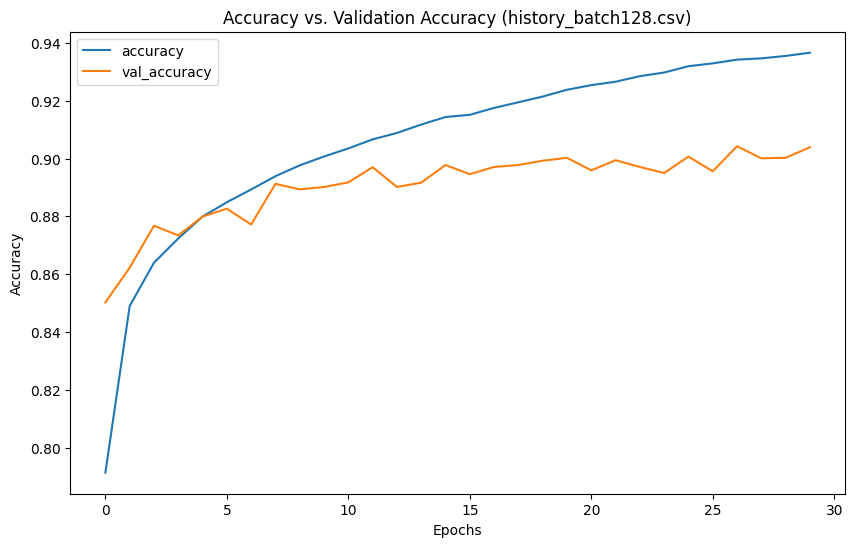

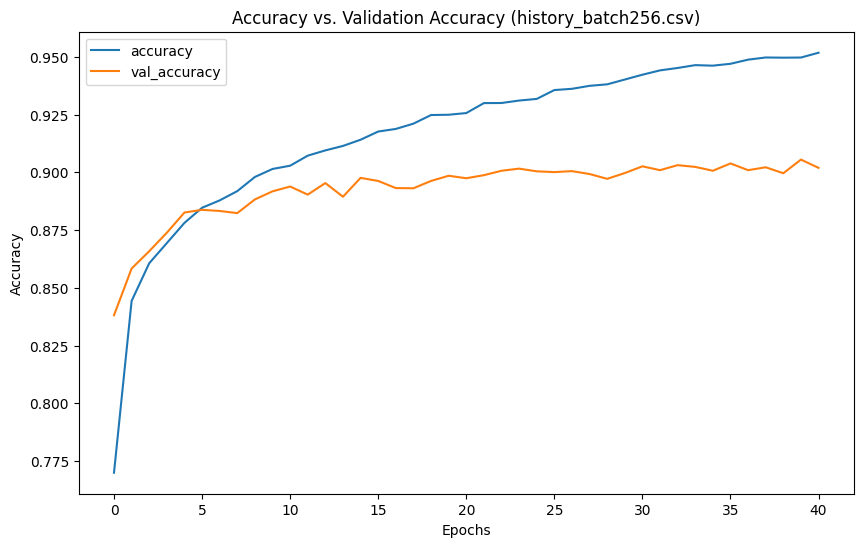

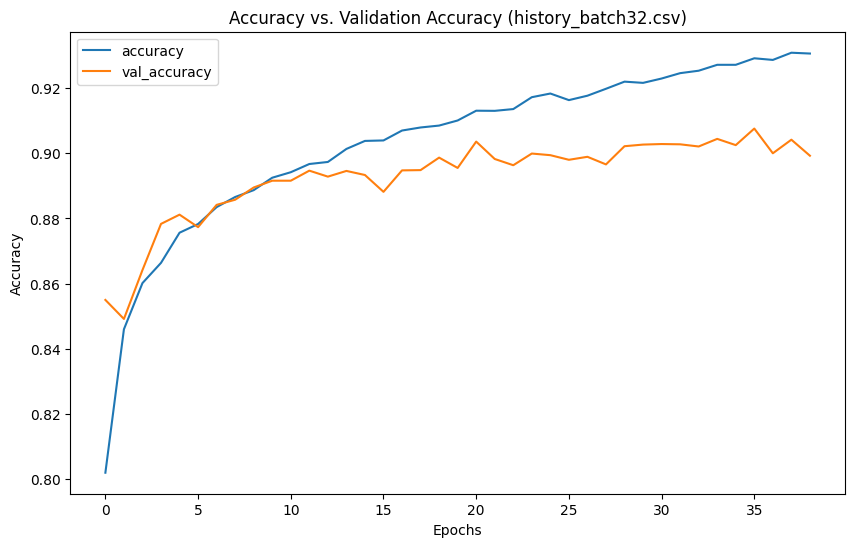

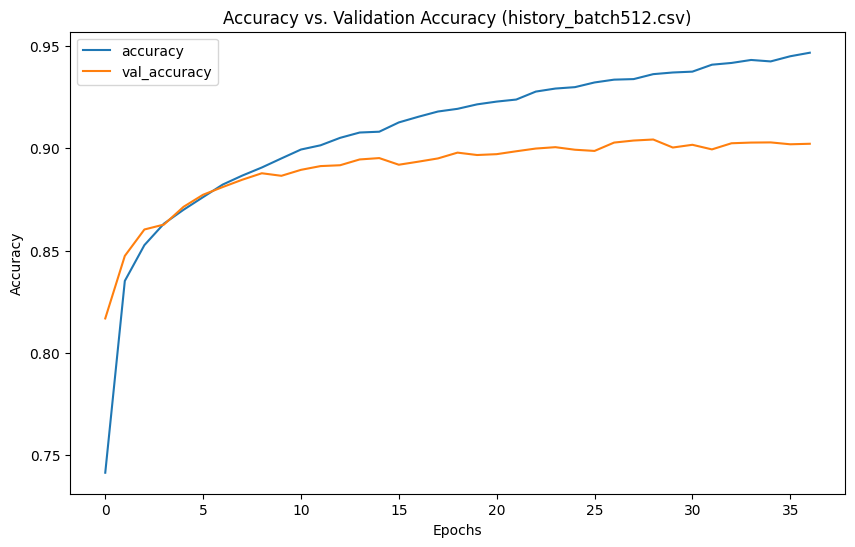

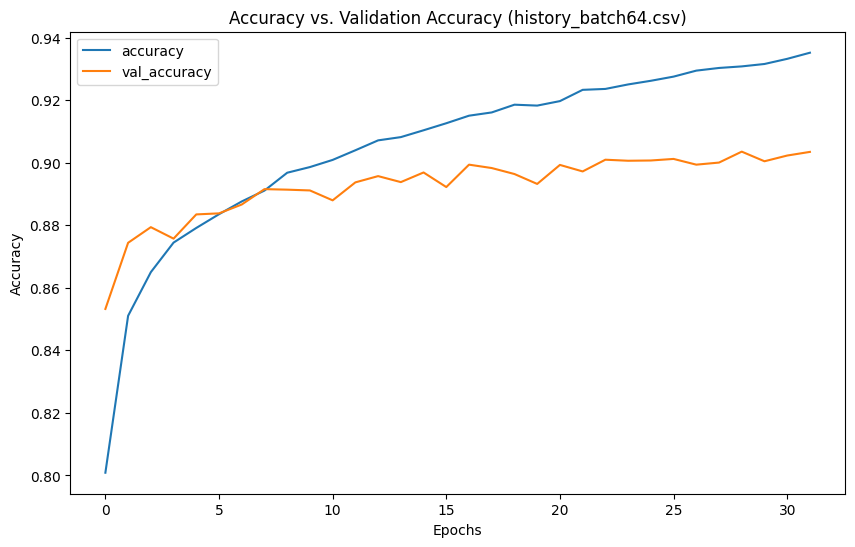

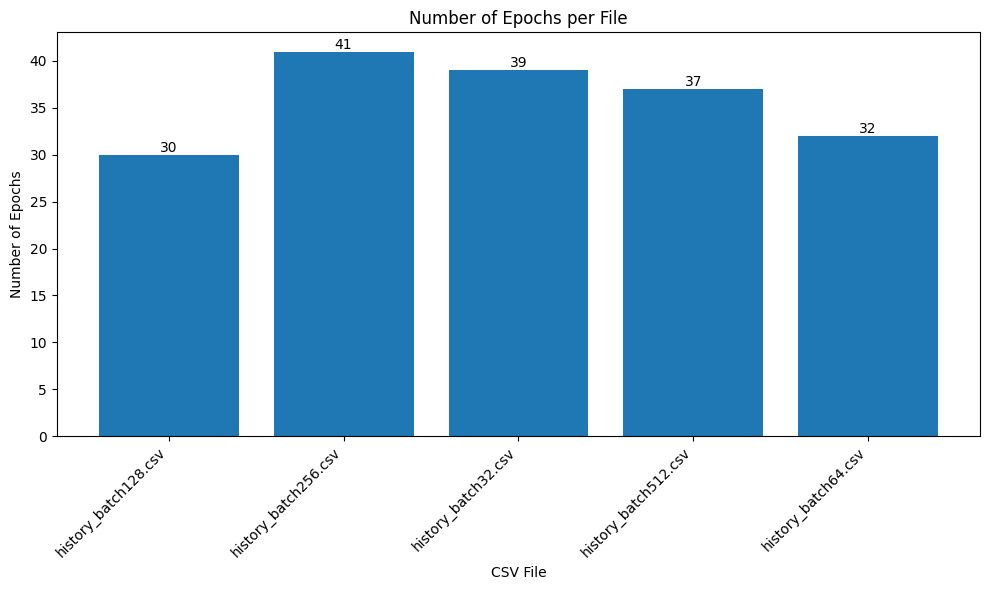

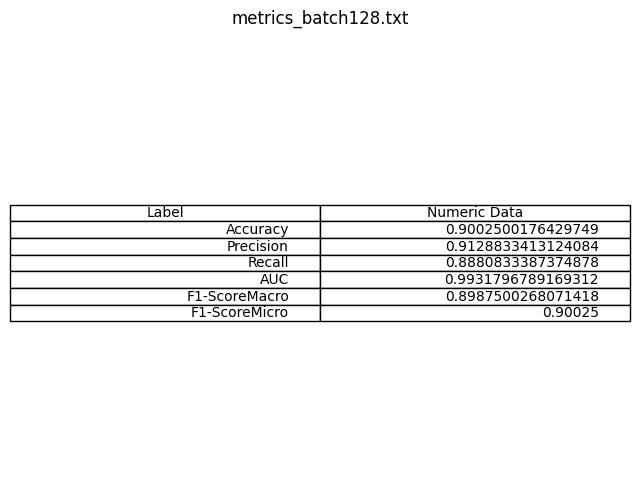

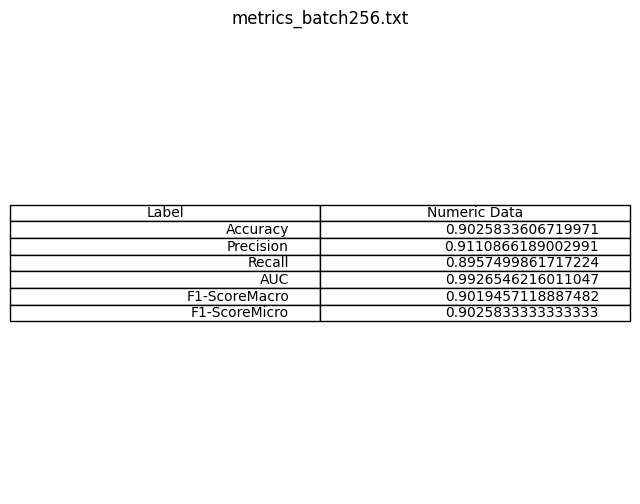

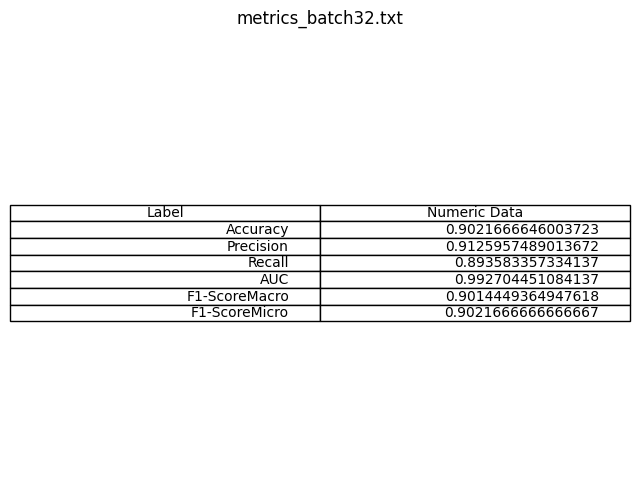

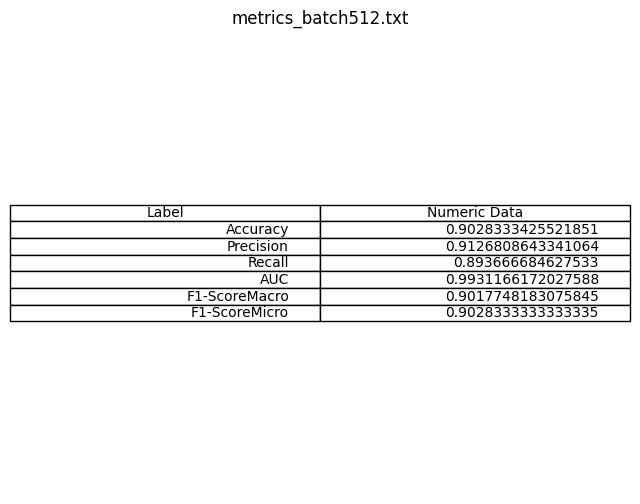

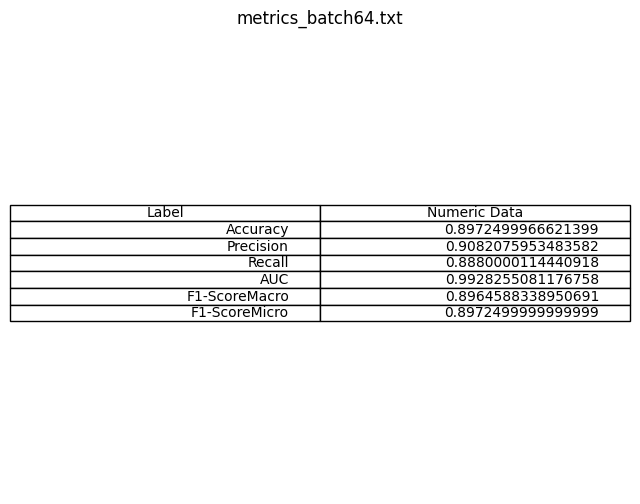

In [30]:
accuracies = []
val_accuracies = []
csv_names = []
csv_files = glob.glob('kaggle/MODELOS/history_batch'+'*.csv')  

for file in csv_files:
    accuracy, val_accuracy = extract_columns(file)
    accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)
    csv_names.append(os.path.basename(file))#')file)
for file in csv_files:
    plot_accuracy_vs_val_accuracy(file)

plot_epochs_per_file(csv_files)

text_files = glob.glob('kaggle/MODELOS/metrics_batch'+'*.txt') 
plot_table_from_text_files(text_files)

#### VS BatchNormalization

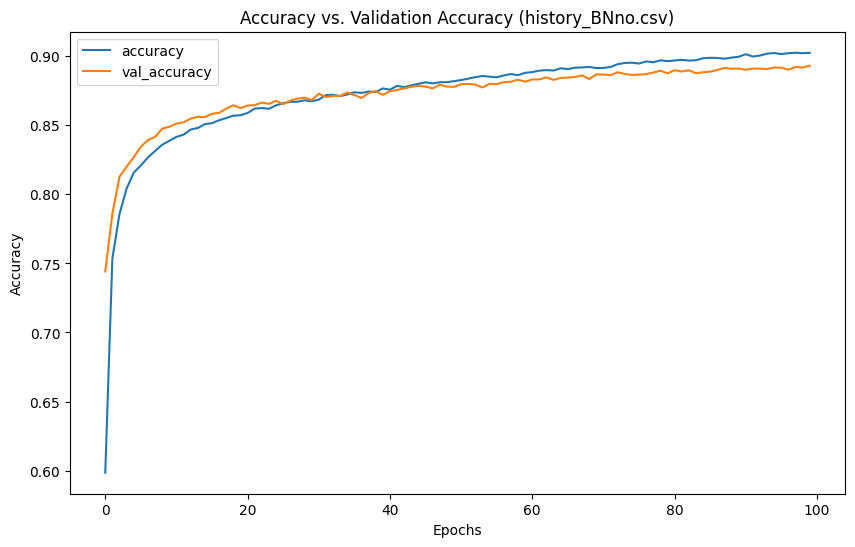

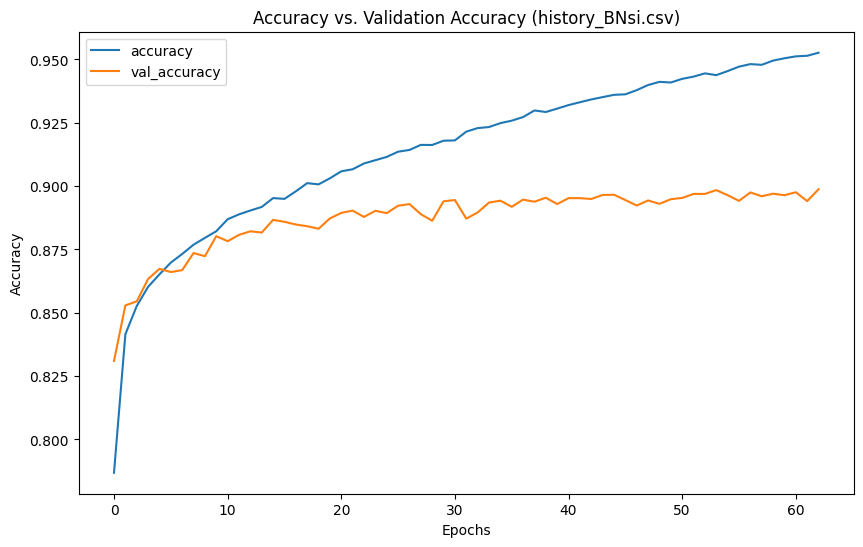

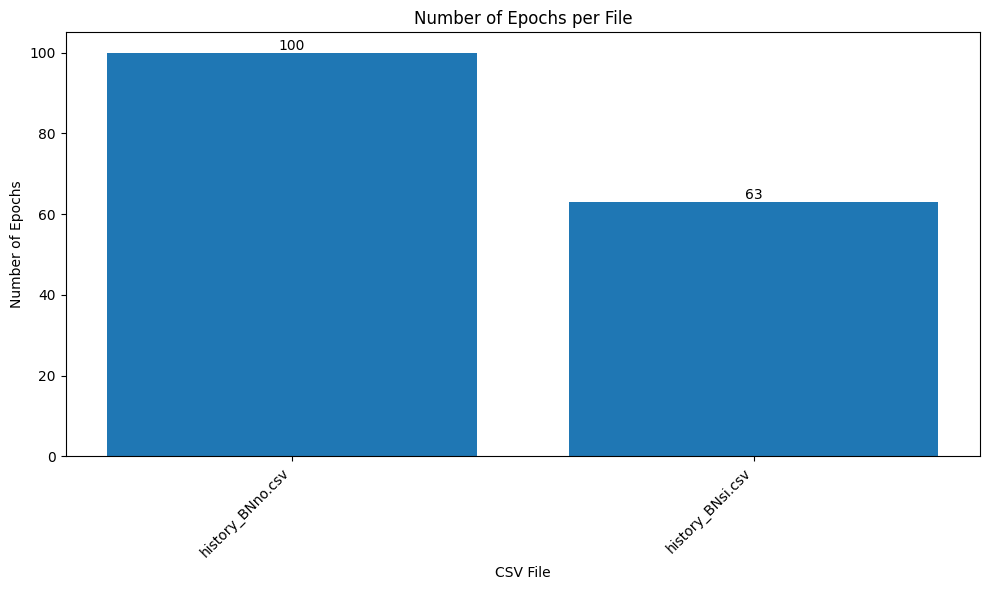

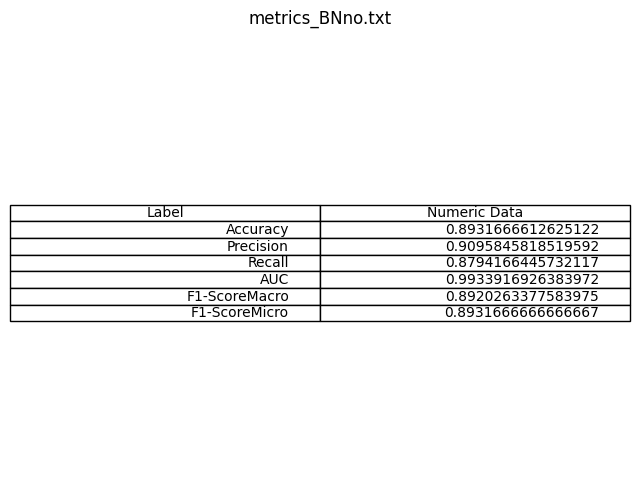

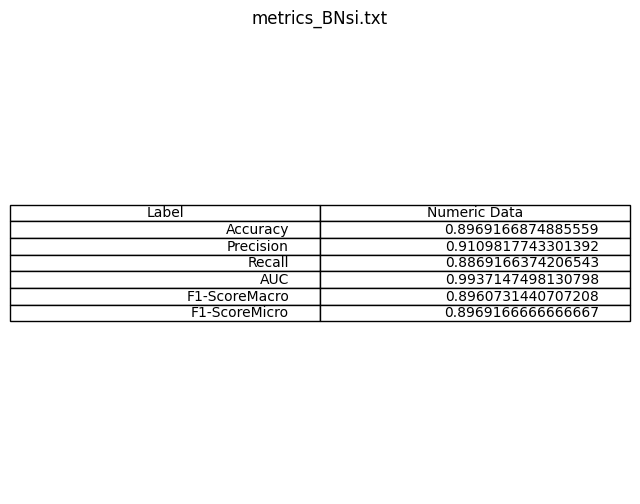

In [31]:
accuracies = []
val_accuracies = []
csv_names = []
csv_files = glob.glob('kaggle/MODELOS/history_BN'+'*.csv')  

for file in csv_files:
    accuracy, val_accuracy = extract_columns(file)
    accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)
    csv_names.append(os.path.basename(file))#')file)
for file in csv_files:
    plot_accuracy_vs_val_accuracy(file)

plot_epochs_per_file(csv_files)

text_files = glob.glob('kaggle/MODELOS/metrics_BN'+'*.txt') 
plot_table_from_text_files(text_files)

#### VS Dropout Rate

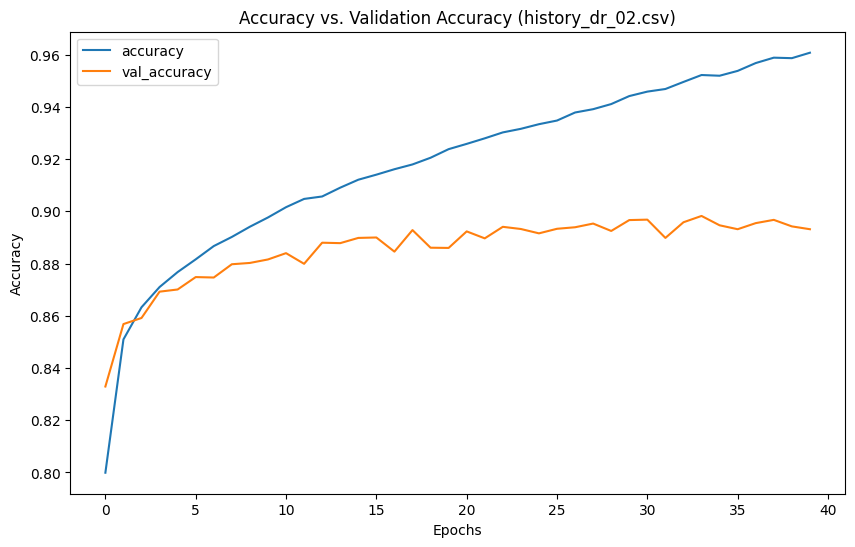

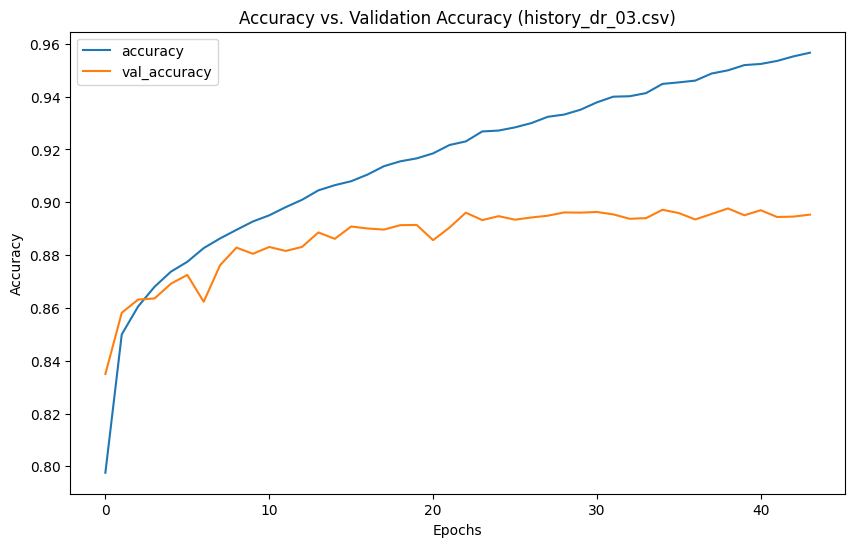

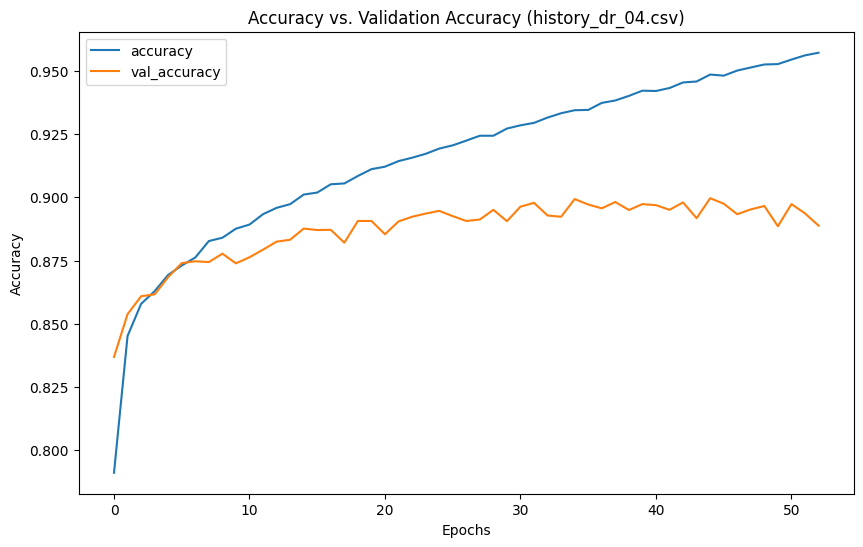

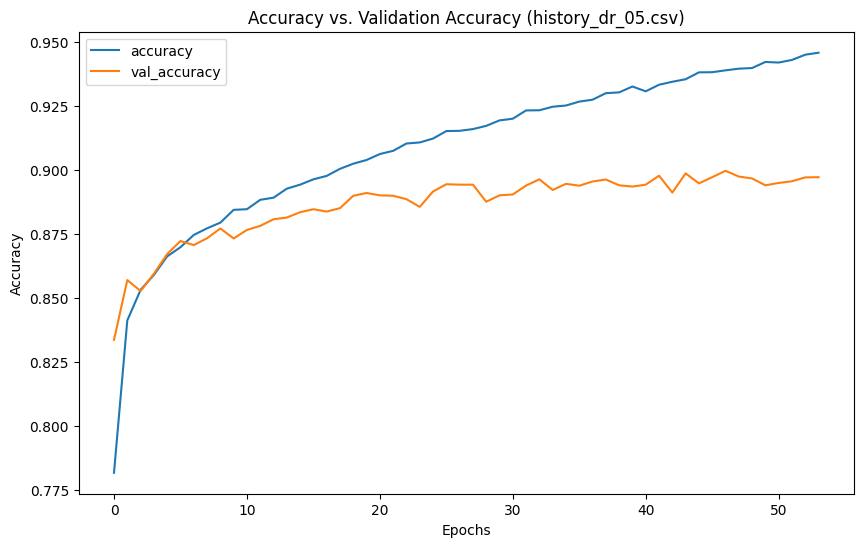

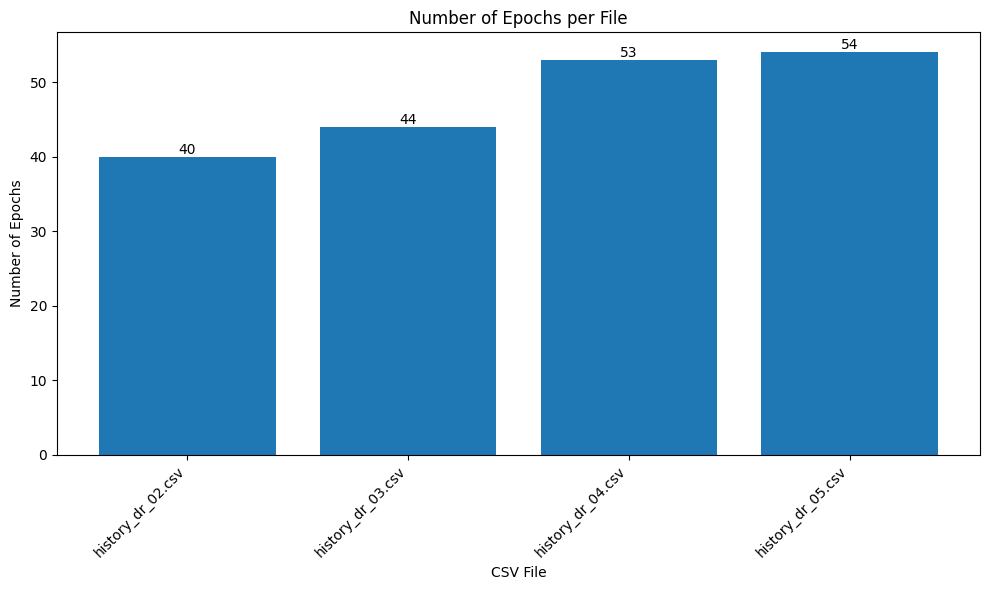

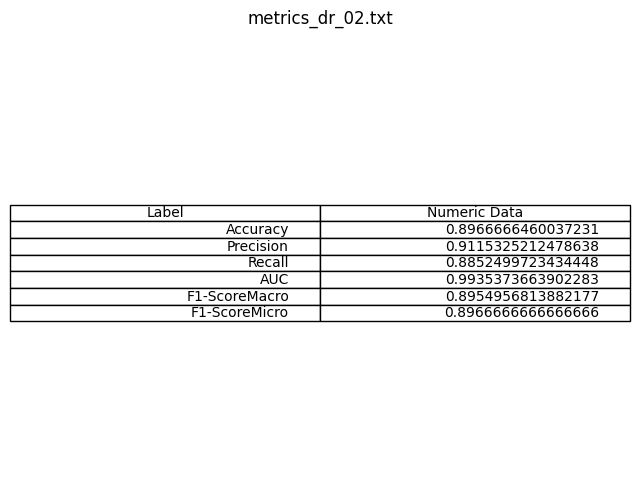

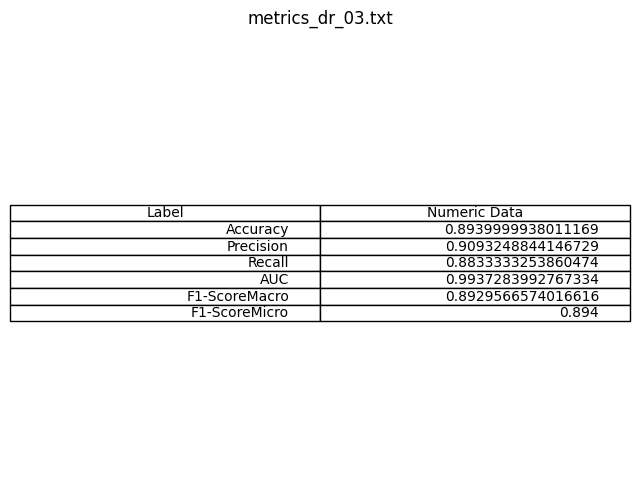

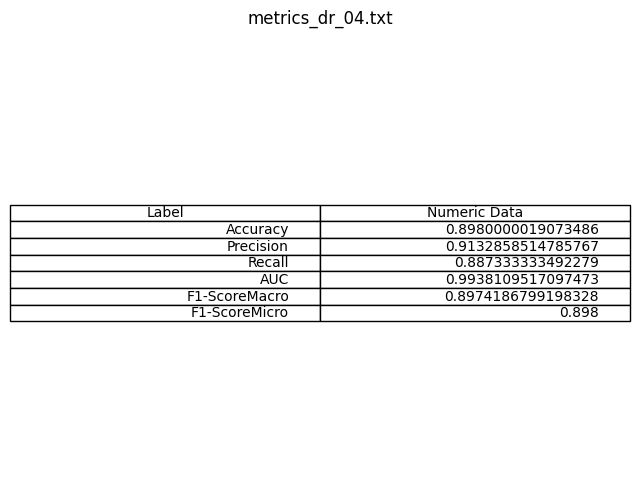

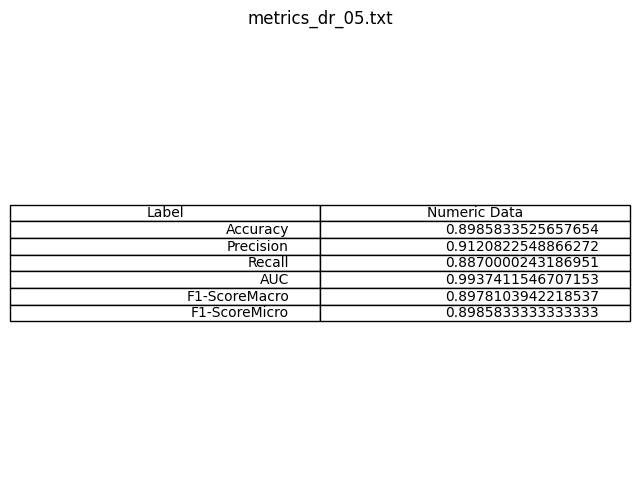

In [32]:
accuracies = []
val_accuracies = []
csv_names = []
csv_files = glob.glob('kaggle/MODELOS/history_dr'+'*.csv')  

for file in csv_files:
    accuracy, val_accuracy = extract_columns(file)
    accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)
    csv_names.append(os.path.basename(file))#')file)
for file in csv_files:
    plot_accuracy_vs_val_accuracy(file)

plot_epochs_per_file(csv_files)

text_files = glob.glob('kaggle/MODELOS/metrics_dr'+'*.txt') 
plot_table_from_text_files(text_files)

#### VS Optimizadores

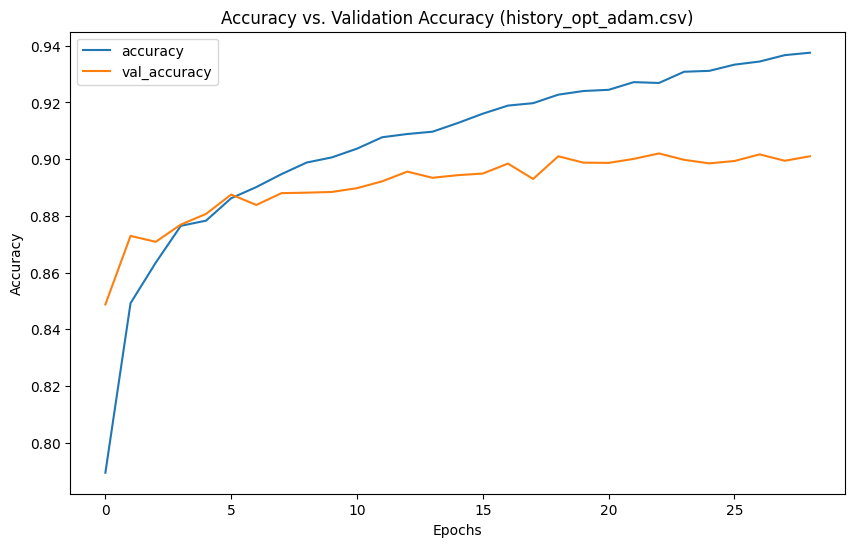

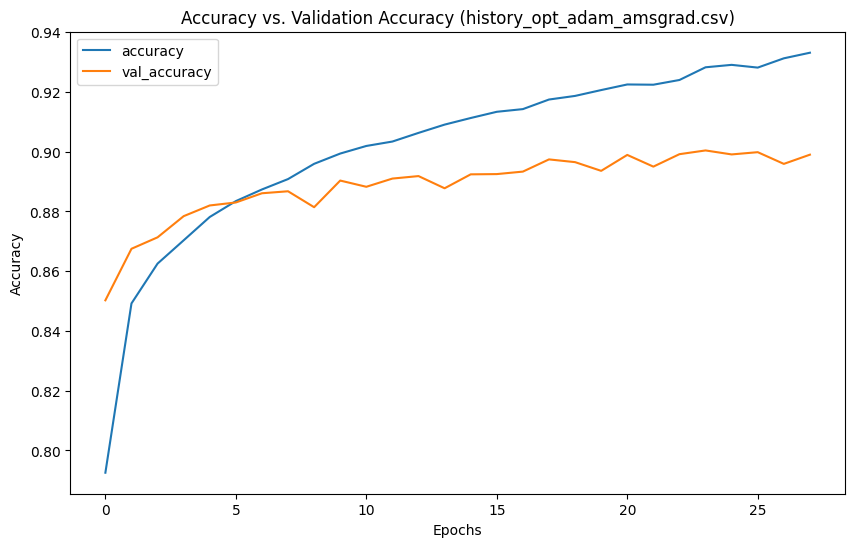

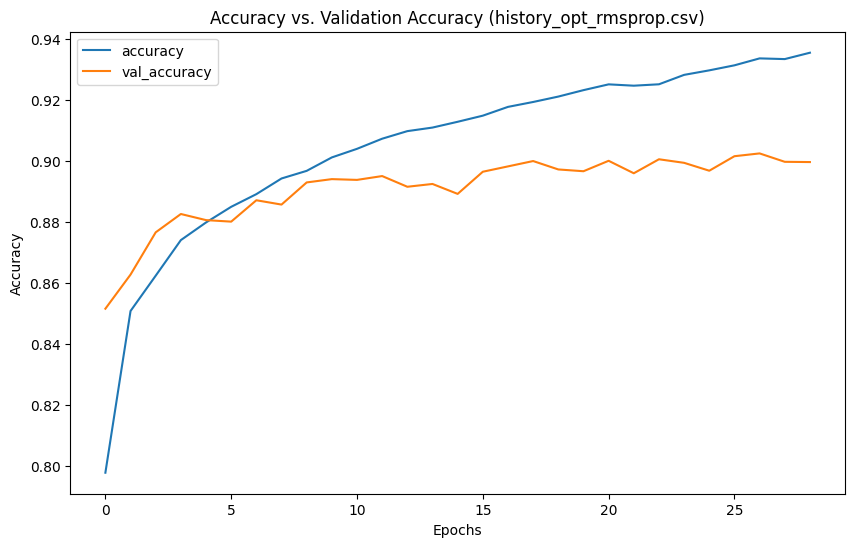

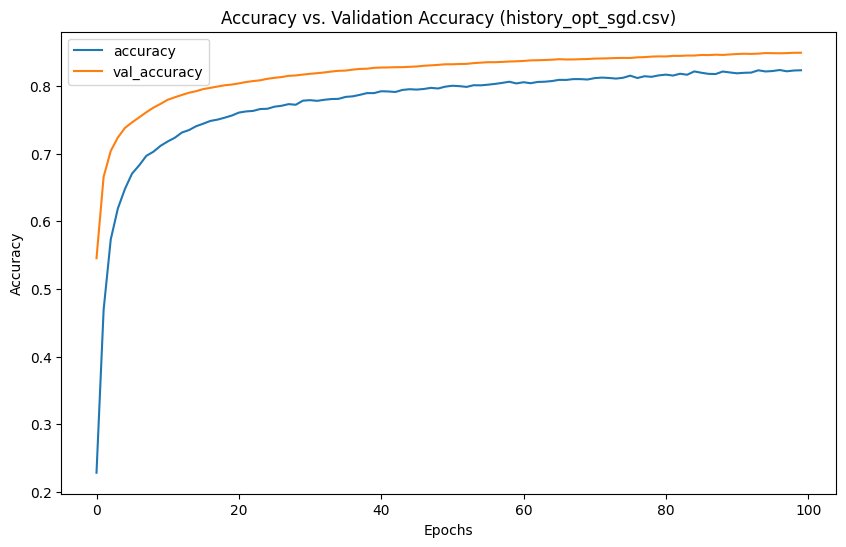

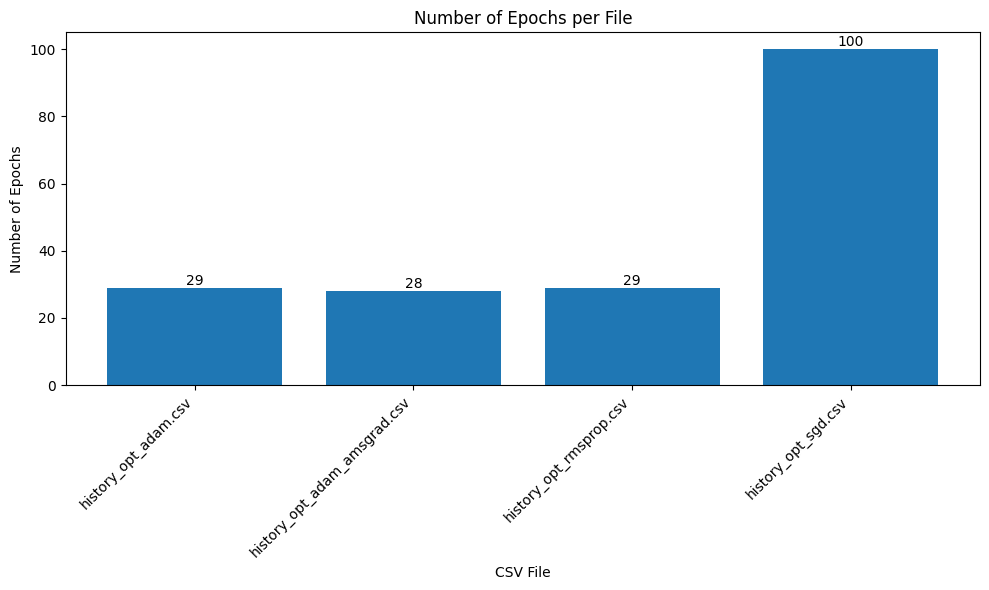

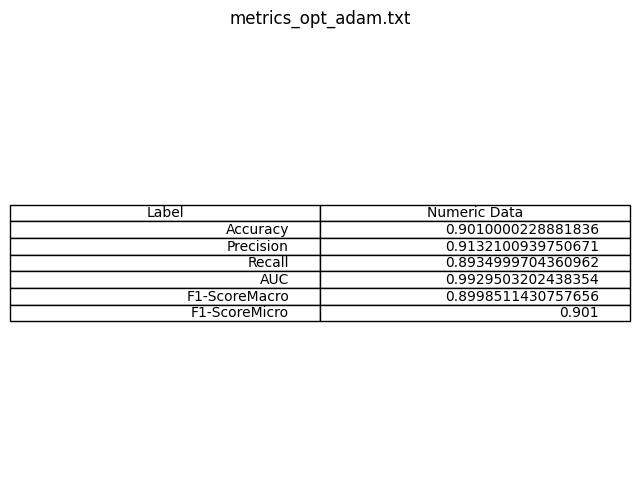

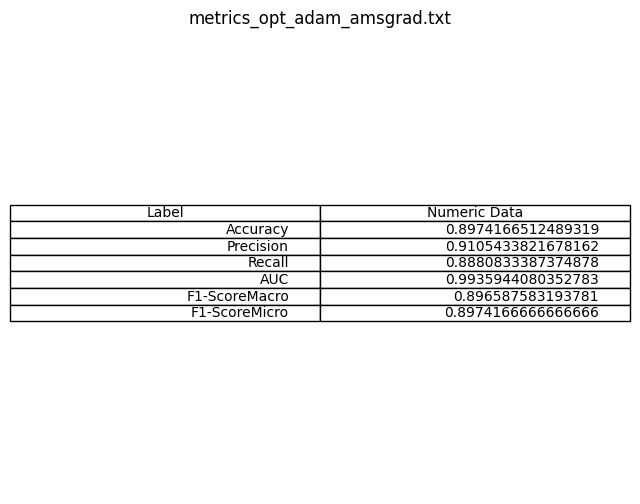

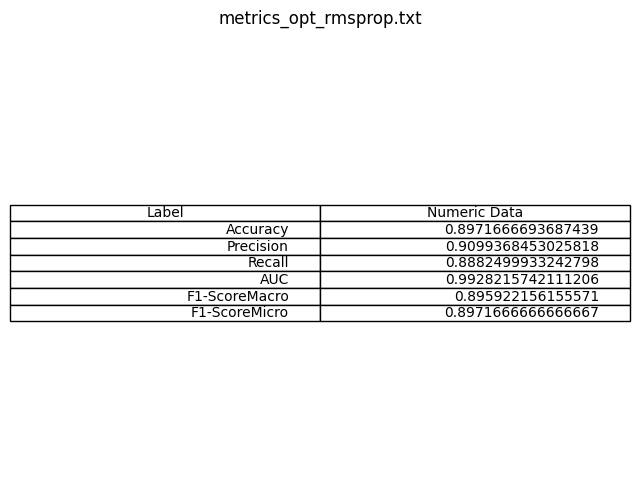

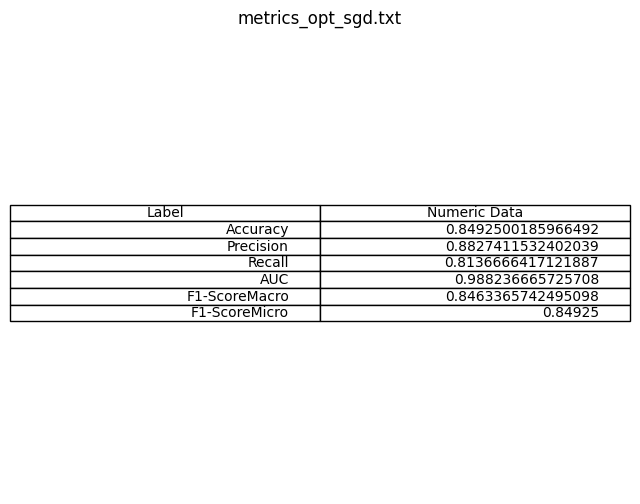

In [33]:
accuracies = []
val_accuracies = []
csv_names = []
csv_files = glob.glob('kaggle/MODELOS/history_opt'+'*.csv')  

for file in csv_files:
    accuracy, val_accuracy = extract_columns(file)
    accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)
    csv_names.append(os.path.basename(file))#')file)
for file in csv_files:
    plot_accuracy_vs_val_accuracy(file)

plot_epochs_per_file(csv_files)

text_files = glob.glob('kaggle/MODELOS/metrics_opt'+'*.txt') 
plot_table_from_text_files(text_files)

# LOTTERY TICKET
Could u have the winning ticket? -> pruned neural networks and performance

##### helper

In [9]:
def modify_the_weights(initial_weights, final_weights):
    weight_diff = [np.abs(initial - final) for initial, final in zip(initial_weights, final_weights)]

    # Flatten and sort weight differences
    flattened_diff = np.concatenate([arr.flatten() for arr in weight_diff])
    sorted_indices = np.argsort(flattened_diff)[::-1]

    # Determine the threshold value for the top 50% weights
    threshold_index = int(len(sorted_indices) * 0.5)
    threshold = flattened_diff[sorted_indices[threshold_index]]

    # Set weights above the threshold to their initial values, and the rest to zero

    modified_weights = []
    for initial, final in zip(initial_weights, final_weights):
        mask = np.abs(final - initial) >= threshold
        modified_weights.append(np.where(mask, initial, 0.0))
    
    return modified_weights

##### code

In [10]:
K.clear_session()
# Load the data
train_imgs = np.load('kaggle/train_images.npy')
train_labels = pd.read_csv('kaggle/train_labels.csv')
x_train, x_val, y_train, y_val = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=40)

# Normalize the images
x_train = x_train / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_val.reshape(-1, 28, 28, 1)
x_train = x_train.reshape(-1, 28,28)
#x_val = x_val.reshape(-1, 28, 28)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)

In [13]:
input_layer = layers.Input(shape=(28, 28))
flatten_layer = layers.Flatten()(input_layer)
hidden_layer1 = layers.Dense(4000, kernel_initializer='glorot_normal', activation='relu')(flatten_layer)
batchnorm_layer = layers.BatchNormalization(synchronized=True)(hidden_layer1)
dropout_layer = layers.Dropout(0.5)(batchnorm_layer)
hidden_layer2 = layers.Dense(4000, kernel_initializer='glorot_normal', activation='relu')(dropout_layer)
output_layer = layers.Dense(10, activation='softmax')(hidden_layer2)


In [14]:

model1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
# Optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.99,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

model1.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
model2.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])



In [16]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
lr_scheduler = LearningRateScheduler(lambda epoch: 0.0001 * 0.95 ** epoch)
checkpoint = ModelCheckpoint('kaggle/MODELOS/ej4_red2_2".h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history = model2.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val),
                    callbacks=[early_stopping, checkpoint, reduce_lr, lr_scheduler]) #entreno red 2

history_df = pd.DataFrame(history.history)
# Save the DataFrame to a CSV file
history_df.to_csv('kaggle/MODELOS/history_ej4_red2_2.csv', index=False)

final_model = model1 #red1
final_model.set_weights(modify_the_weights(model1.get_weights(), model2.get_weights()))#red3

test_loss, accuracy, precision, recall, auc = final_model.evaluate(x_val, y_val, verbose=1)
print(test_loss, accuracy) #de la red3



Epoch 1/20
375/375 [==============================] - ETA: 0s - loss: 0.4681 - accuracy: 0.8409 - precision_3: 0.8609 - recall_3: 0.8232 - auc_3: 0.9849
Epoch 1: val_loss improved from inf to 0.39940, saving model to kaggle/MODELOS\ej4_red2.h5
375/375 [==============================] - 195s 520ms/step - loss: 0.4681 - accuracy: 0.8409 - precision_3: 0.8609 - recall_3: 0.8232 - auc_3: 0.9849 - val_loss: 0.3994 - val_accuracy: 0.8602 - val_precision_3: 0.8840 - val_recall_3: 0.8382 - val_auc_3: 0.9895 - lr: 1.0000e-04
Epoch 2/20
375/375 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.8653 - precision_3: 0.8826 - recall_3: 0.8505 - auc_3: 0.9889
Epoch 2: val_loss improved from 0.39940 to 0.37725, saving model to kaggle/MODELOS\ej4_red2.h5
375/375 [==============================] - 195s 521ms/step - loss: 0.3894 - accuracy: 0.8653 - precision_3: 0.8826 - recall_3: 0.8505 - auc_3: 0.9889 - val_loss: 0.3772 - val_accuracy: 0.8708 - val_precision_3: 0.8846 - val_recall

In [21]:

cortando_pesos =LambdaCallback(
    on_batch_end=lambda epoch,logs: final_model.set_weights(modify_the_weights(model1.get_weights(), model2.get_weights()))) 
history= final_model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_val, y_val),
                    callbacks=[early_stopping, reduce_lr, lr_scheduler, cortando_pesos])

history_df = pd.DataFrame(history.history)
history_df.to_csv('kaggle/MODELOS/history_ej4_redfinal_2.csv', index=False)

Epoch 1/15
375/375 [==============================] - 188s 500ms/step - loss: 0.1745 - accuracy: 0.9351 - precision_2: 0.9415 - recall_2: 0.9294 - auc_2: 0.9974 - val_loss: 0.3460 - val_accuracy: 0.8960 - val_precision_2: 0.9046 - val_recall_2: 0.8900 - val_auc_2: 0.9900 - lr: 1.0000e-04
Epoch 2/15
375/375 [==============================] - 188s 501ms/step - loss: 0.1727 - accuracy: 0.9377 - precision_2: 0.9448 - recall_2: 0.9315 - auc_2: 0.9973 - val_loss: 0.3616 - val_accuracy: 0.8944 - val_precision_2: 0.9016 - val_recall_2: 0.8897 - val_auc_2: 0.9890 - lr: 9.5000e-05
Epoch 3/15
375/375 [==============================] - 191s 508ms/step - loss: 0.1662 - accuracy: 0.9379 - precision_2: 0.9442 - recall_2: 0.9316 - auc_2: 0.9976 - val_loss: 0.3725 - val_accuracy: 0.8908 - val_precision_2: 0.8986 - val_recall_2: 0.8860 - val_auc_2: 0.9887 - lr: 9.0250e-05
Epoch 4/15
375/375 [==============================] - 195s 519ms/step - loss: 0.1588 - accuracy: 0.9405 - precision_2: 0.9471 - recal

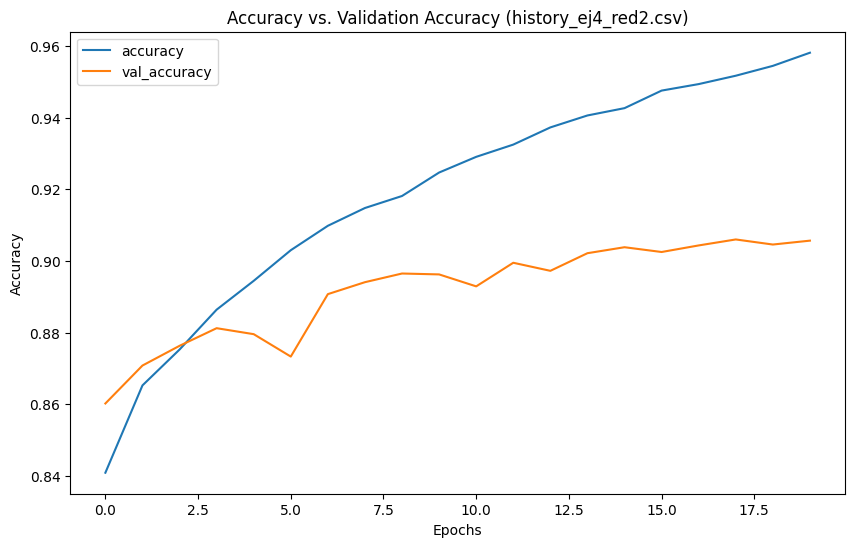

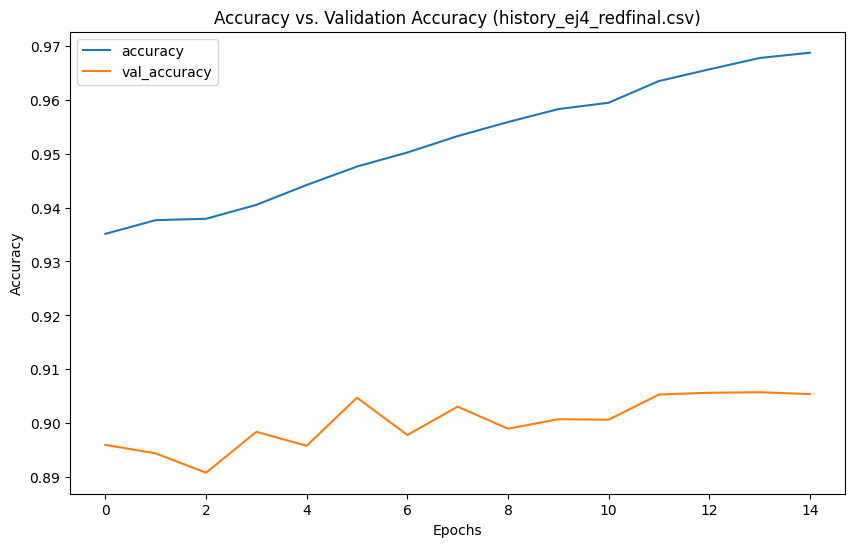

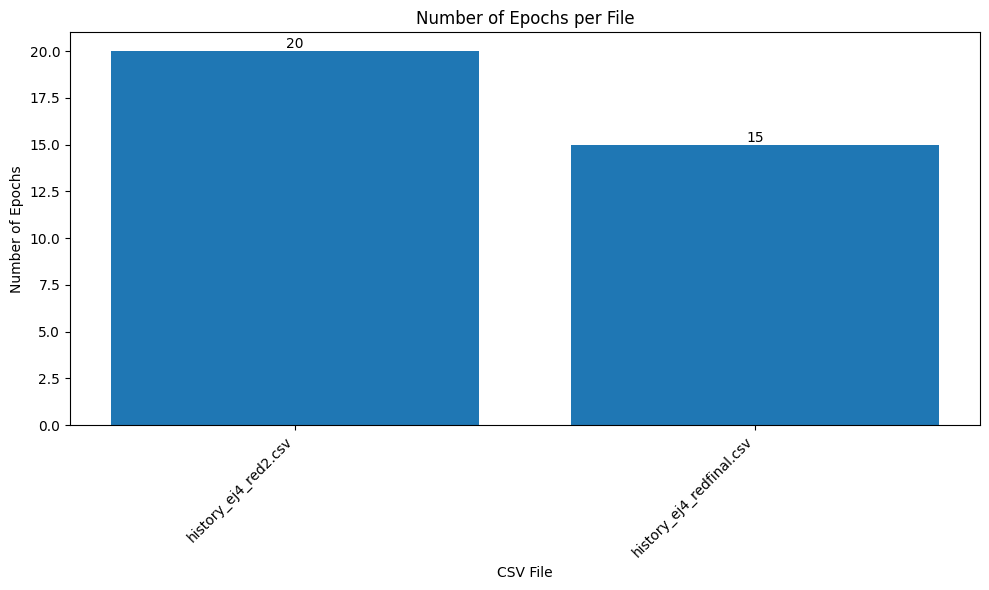

In [22]:
accuracies = []
val_accuracies = []
csv_names = []
csv_files = glob.glob('kaggle/MODELOS/history_ej4_red'+'*.csv')  

for file in csv_files:
    accuracy, val_accuracy = extract_columns(file)
    accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)
    csv_names.append(os.path.basename(file))#')file)
for file in csv_files:
    plot_accuracy_vs_val_accuracy(file)

plot_epochs_per_file(csv_files)

# Submission Generator

In [ ]:
test_images = np.load('kaggle/test_images.npy')/255
submission = pd.DataFrame()
submission["id"] = np.arange(len(test_images))
submission["Category"] = np.argmax(model.predict(test_images),(1))
submission.to_csv("kaggle/submission_conesteroides2.csv", index=False)